# Rozpoznawanie awarii urządzenia - modele oparte o CNN

**Autorzy:** Patryk Śledź, Weronika Ciurej, Aleksandra Rolka

# Wczytanie danych

In [86]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns

from keras import metrics
import sklearn
import keras
from sklearn.metrics import precision_score
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import KFold

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
# !pip install livelossplot
from livelossplot import PlotLossesKeras
# !pip install shap
# import shap

In [87]:
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score

In [88]:
# Make numpy values easier to read.|
np.set_printoptions(precision=3, suppress=True)

Kod umożliwiający połączenie z osobistym dyskiem google. Pliki wczytywane z folderu SSN-projekt/data oraz SSN-projekt/models.

In [11]:
from google.colab import drive

drive.mount('/content/gdrive')
project_folder_path = '/content/gdrive/MyDrive/SSN-projekt'
data_path = project_folder_path + '/data'
models_path = project_folder_path + '/models'

ModuleNotFoundError: No module named 'google.colab'

Alternatywnie, można przesłać archiwum .zip pomiarów - data_set.zip do folderu projektu.

In [89]:
# #data_set.zip must be uploaded to content
# !unzip data_set.zip

# #filenames
fault_filenames = glob.glob("data/data*_fault.csv")
normal_filenames = glob.glob("data/data*_normal.csv")

#columnnames
column_names = ["time", "P1", "P2", "P3", "P4","P5", "P6", "P7", "P8", "P9"]
# !rm -rf /content/data

project_folder_path = '.'
data_path = project_folder_path + '/data'
models_path = project_folder_path + '/models'

In [90]:
#filenames
fault_filenames = glob.glob(data_path + "/data*_fault.csv")
normal_filenames = glob.glob(data_path + "/data*_normal.csv")

#columnnames
column_names = ["time", "P1", "P2", "P3", "P4","P5", "P6", "P7", "P8", "P9"]

# Analiza danych

Przegląd danych podzieliliśmy na analizę pomiarów bez standaryzacji oraz danych ustandaryzowanych za pomocą funkcji *StandardScaler()* z biblioteki *sklearn*

# Analiza danych - bez standaryzacji

In [91]:
# read files to list of Dataframes
fault_devices = [pd.read_csv(fault_file, names=column_names) for fault_file in fault_filenames]
normal_devices = [pd.read_csv(normal_file,names=column_names) for normal_file in normal_filenames]

# merge features fault + devices without time column
X = np.asarray([x.iloc[:, 1:].to_numpy() for x in fault_devices] + [x.iloc[:, 1:].to_numpy() for x in normal_devices])
# merge output without time column
Y = np.hstack((np.full((1,len(fault_devices)), 0)[0], np.full((1,len(normal_devices)), 1)[0]))
print("Num of fault: ", len(fault_devices))
print("Num of normal: ", len(normal_devices))
print("Num of all: ", len(X))
print("Headers: ",fault_devices[0].columns.values)
print(fault_devices[0].to_markdown())

Num of fault:  54
Num of normal:  53
Num of all:  107
Headers:  ['time' 'P1' 'P2' 'P3' 'P4' 'P5' 'P6' 'P7' 'P8' 'P9']
|    |   time |   P1 |   P2 |   P3 |   P4 |   P5 |   P6 |   P7 |   P8 |   P9 |
|---:|-------:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|
|  0 |      1 | 30.8 |   16 | 21.4 |   29 |  120 |  5.5 | 57.6 | 35.6 | 15   |
|  1 |      2 | 30.6 |   17 | 21.4 |   29 |   60 |  5.8 | 48.9 | 35.1 | 15.5 |
|  2 |      3 | 30.4 |   17 | 21.4 |   29 |  120 |  5.9 | 43.3 | 34.7 | 16.3 |
|  3 |      4 | 30.2 |   17 | 21.4 |   29 |  120 |  6.1 | 47.8 | 35.4 | 17.1 |
|  4 |      5 | 30.3 |   17 | 21.3 |   29 |  600 |  5.9 | 67.9 | 39.7 | 16.4 |
|  5 |      6 | 30.7 |   17 | 21.4 |   29 |  660 |  5.6 | 70.6 | 40.1 | 15.8 |
|  6 |      7 | 31.1 |   17 | 21.4 |   29 |  540 |  5.3 | 69.7 | 38.6 | 15.3 |
|  7 |      8 | 31.2 |   17 | 21.4 |   29 |  120 |  5.5 | 58.8 | 37.2 | 15.3 |
|  8 |      9 | 31   |   17 | 21.4 |   29 |   60 |  5.8 | 50.1 | 36.5 | 15.8 |
|  9 |     10

### Wizualizacja średnich pomiarów poszczególnych parametrów z każdego dnia:

All parameters in time (AVG all days)


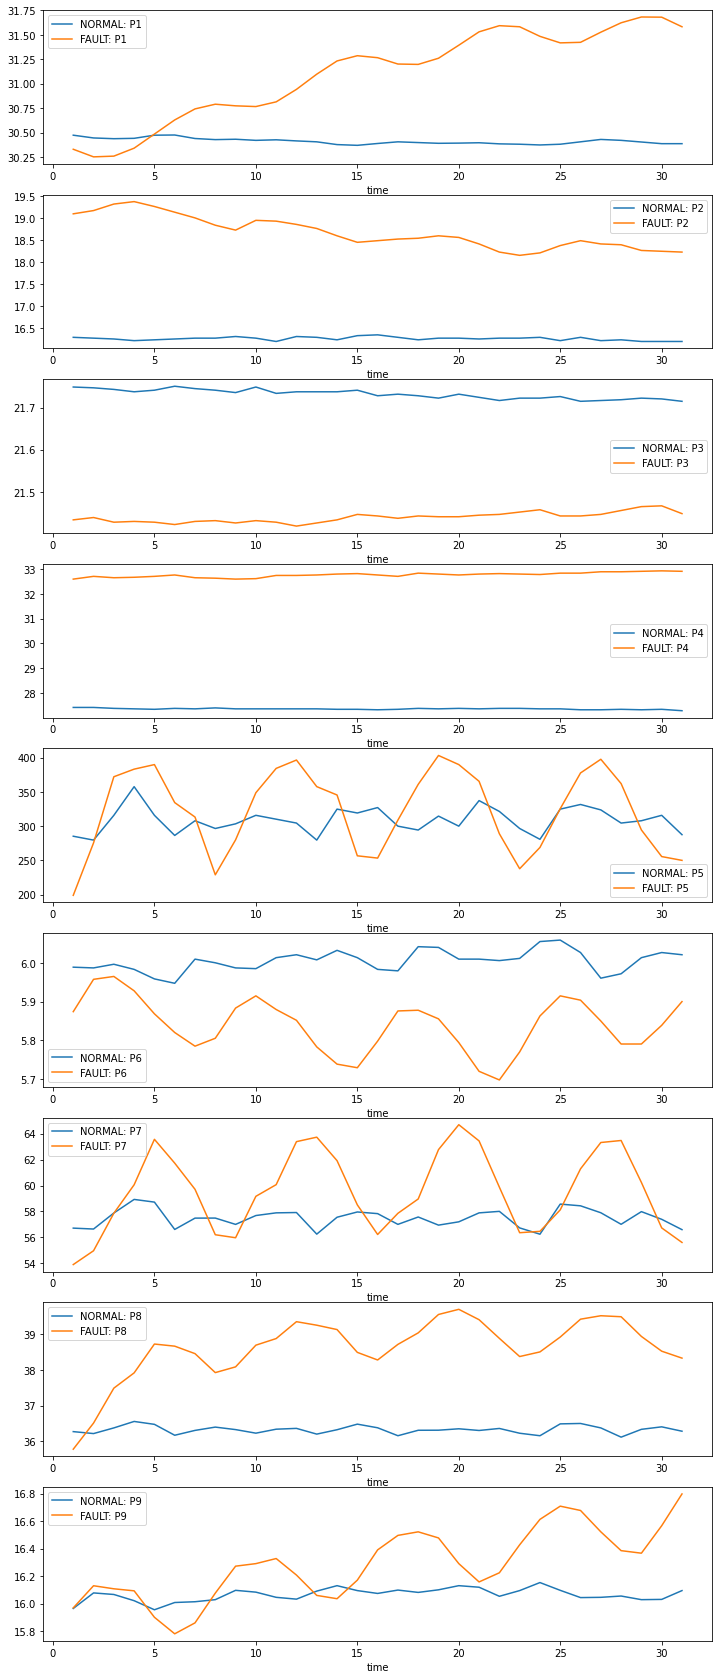

In [92]:
from functools import reduce

print("All parameters in time (AVG all days)")

avg_normal_devices = normal_devices.copy() 
avg_normal_devices = reduce(pd.DataFrame.add, avg_normal_devices)/len(avg_normal_devices)
avg_fault_devices = fault_devices.copy()
avg_fault_devices = reduce(pd.DataFrame.add, avg_fault_devices)/len(avg_fault_devices)

fig, axs = plt.subplots(9, 1, figsize=(12,30))
for i in range(1, len(column_names)):
  avg_normal_devices.plot(x='time', y=column_names[i], kind = 'line', ax=axs[i-1])
  avg_fault_devices.plot(x='time', y=column_names[i], kind = 'line', ax=axs[i-1])
  axs[i-1].legend(["NORMAL: " + column_names[i], "FAULT: " + column_names[i]]);
plt.show()

Jak można zauważyć na powyższych wykresach dla poczególnych danych, widać znaczącą różnice wyników w przypadku danych zebranych podczas awarii urządzenia.

### Wyresy statystyczne poszczególnych parametrów: średnia, standardowe odchylenie, mediana

In [ ]:
# percentile list
perc =[.20, .40, .60, .80]
  
# list of dtypes to include
include =['object', 'float', 'int']

devices_desc = []
mean = []
std = []
median = []

for fault in fault_devices:
  mean.append(fault.describe(percentiles = perc, include = include).loc[['mean']])
  std.append(fault.describe(percentiles = perc, include = include).loc[['std']])
  median_df = pd.DataFrame(fault.median(axis='rows')).transpose()
  median_df.index = ['median']
  median.append(median_df)
  

for normal in normal_devices:
  mean.append(normal.describe(percentiles = perc, include = include).loc[['mean']])
  std.append(normal.describe(percentiles = perc, include = include).loc[['std']])
  median_df = pd.DataFrame(normal.median(axis='rows')).transpose()
  median_df.index = ['median']
  median.append(median_df)

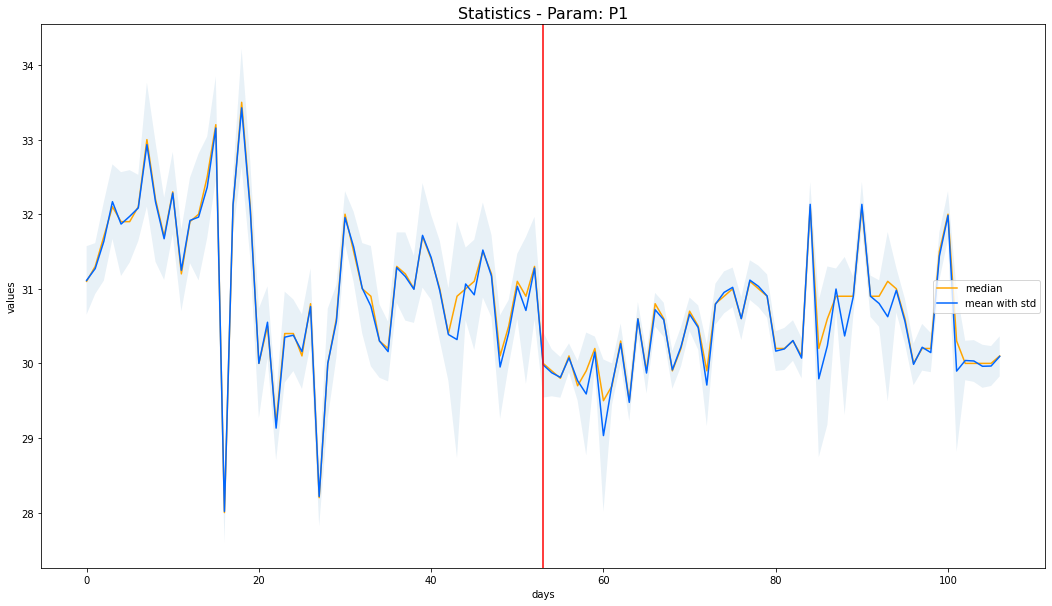

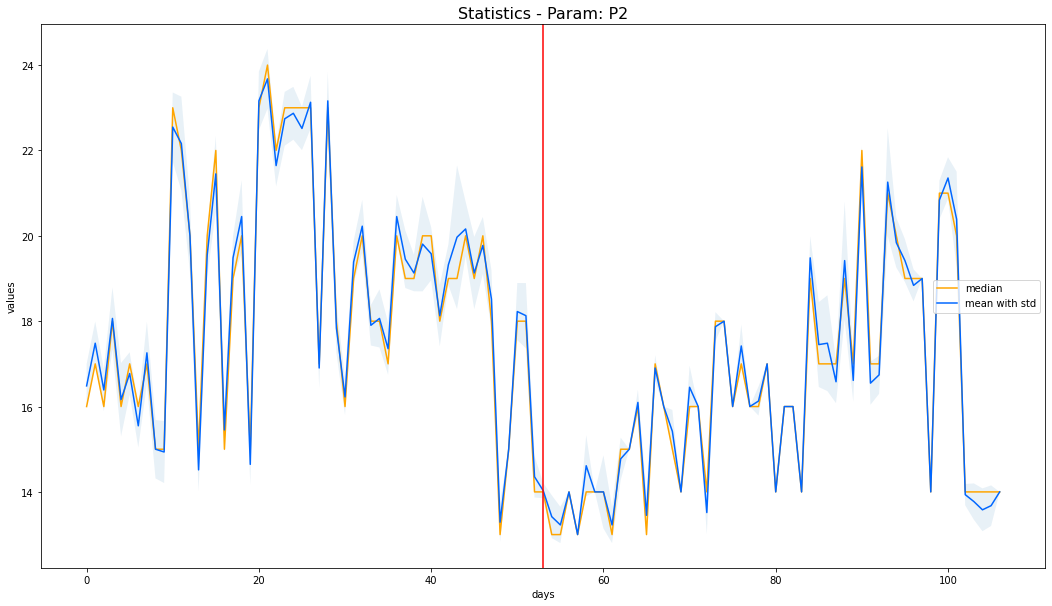

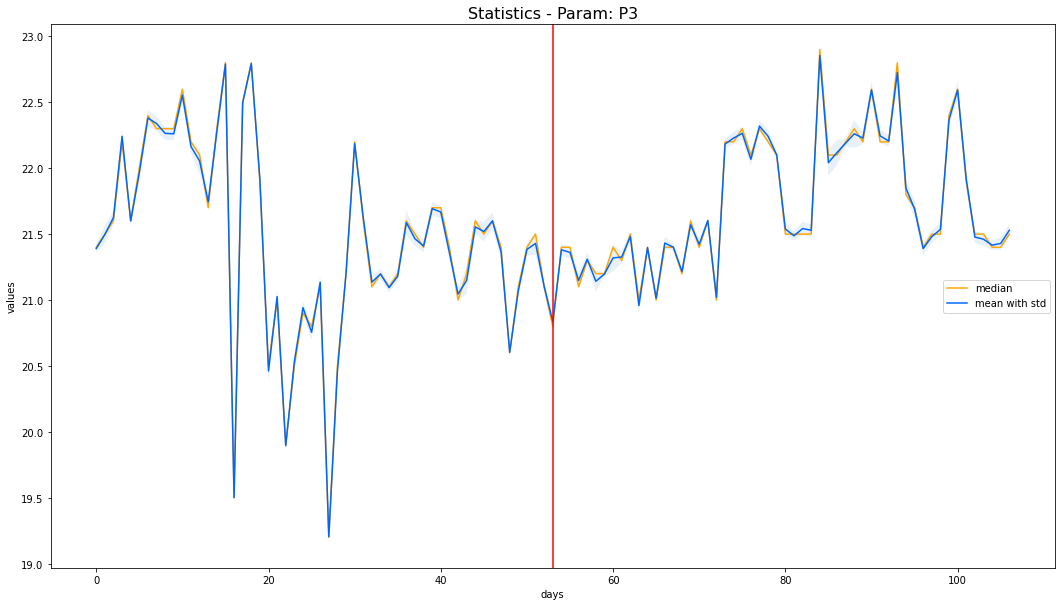

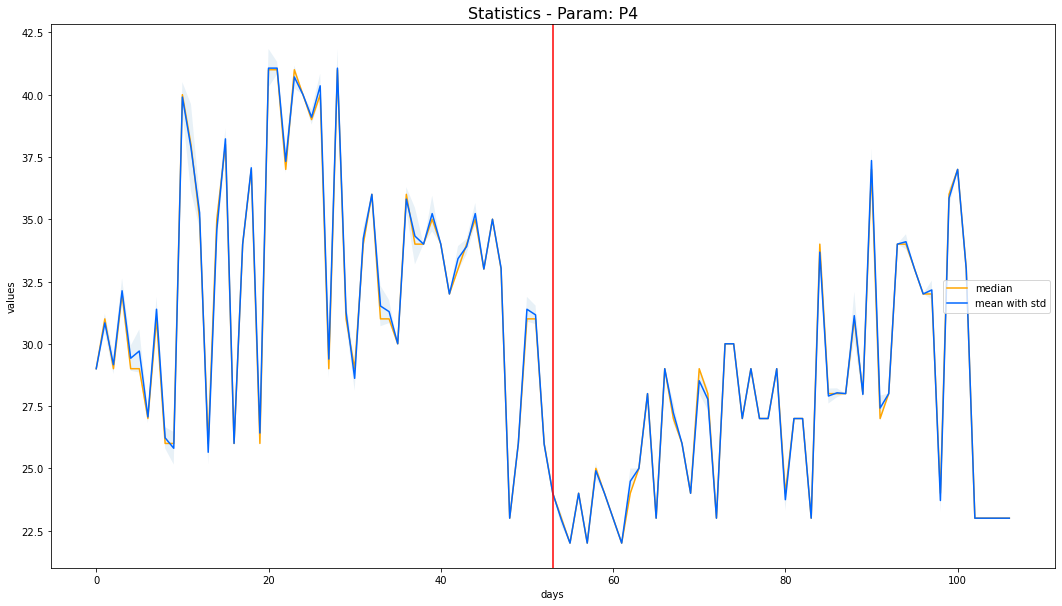

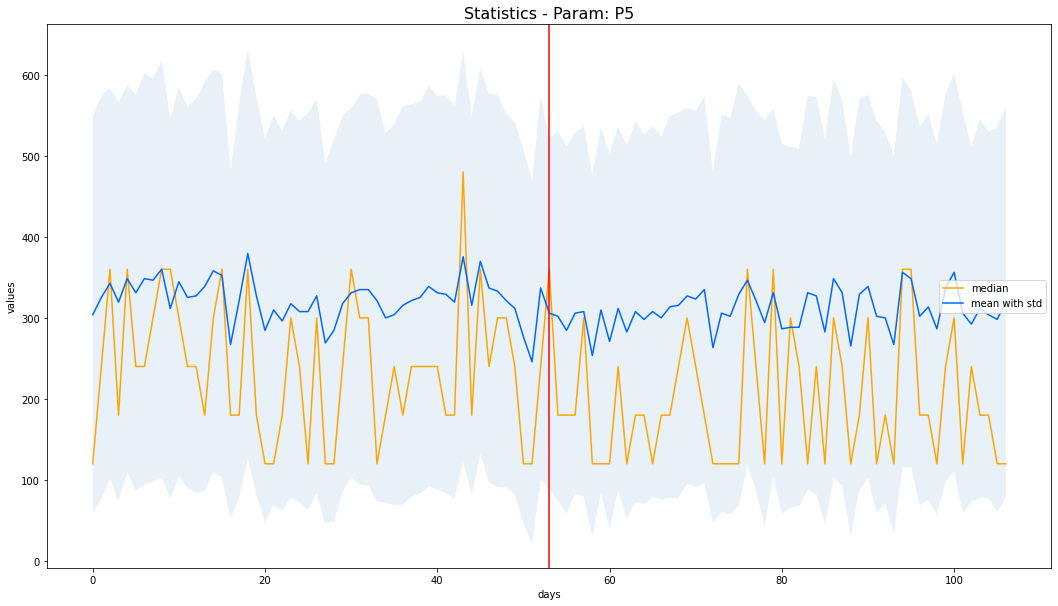

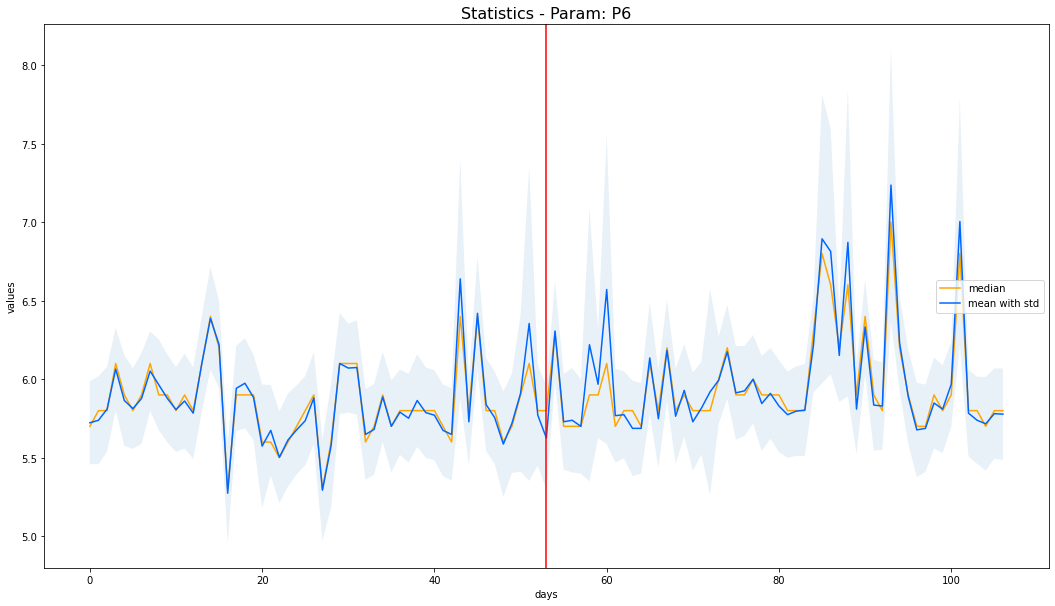

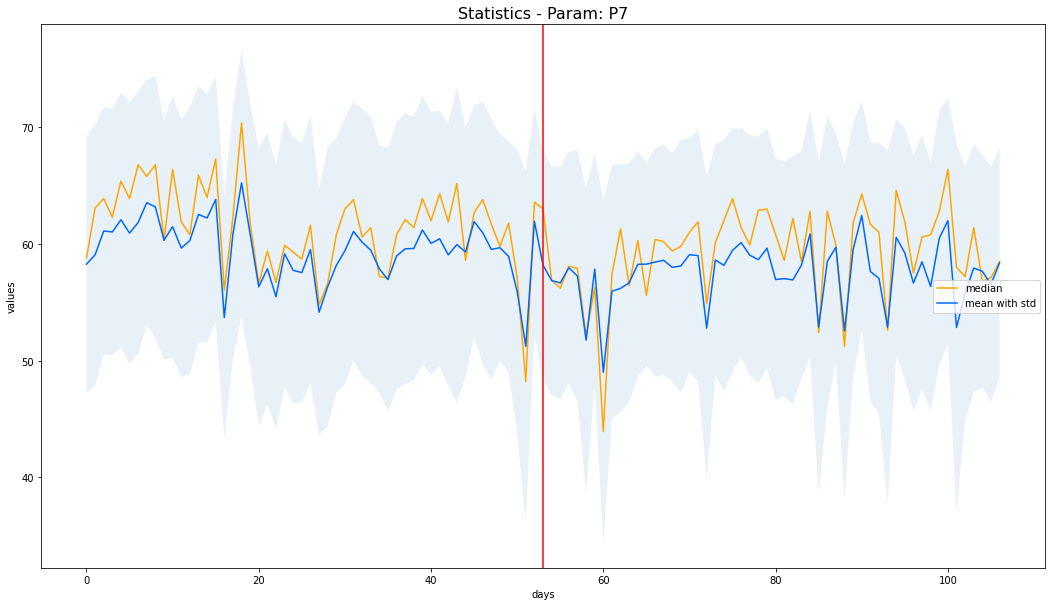

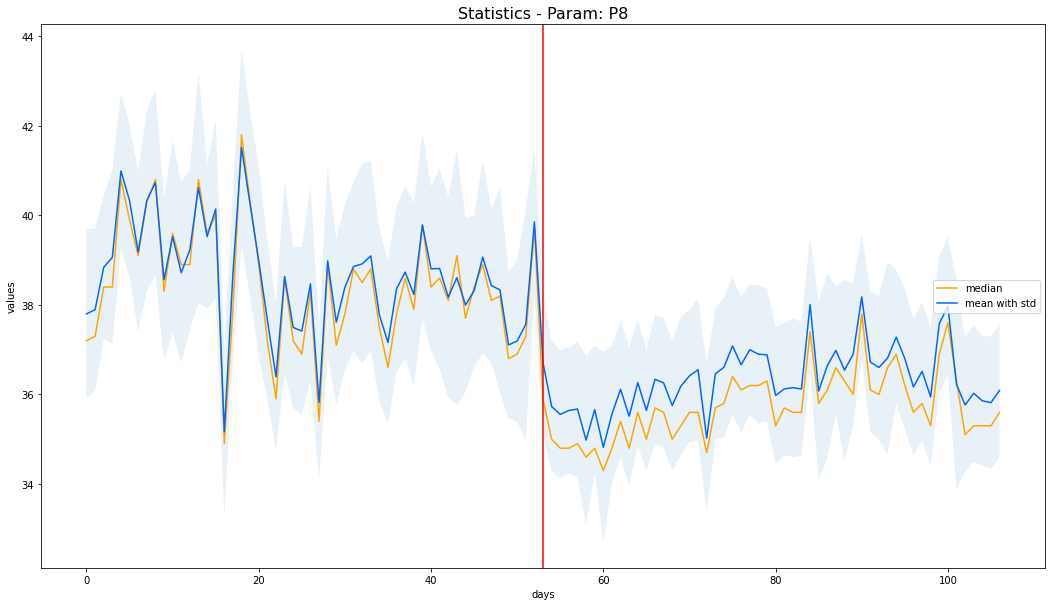

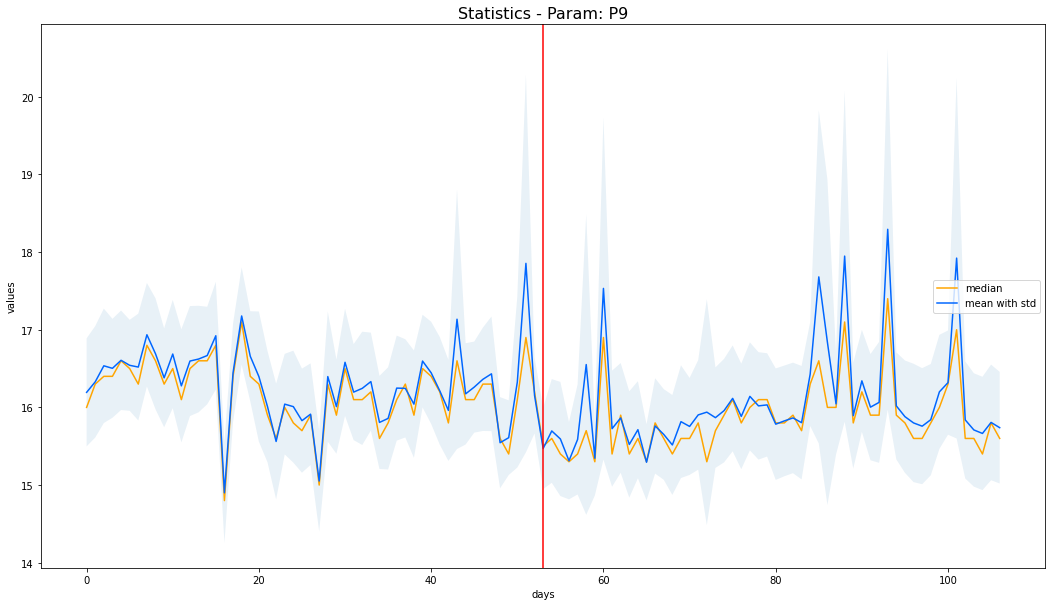

In [ ]:
plt.rcParams["figure.figsize"] = (18,10)
for params in column_names[1:]:
  plt.title("Statistics - Param: " + params, fontsize=16)
  p_median = [x[params] for x in median]
  p_mean = [x[params].values.tolist()[0] for x in mean]
  p_std = [x[params].values.tolist()[0] for x in std]
  plt.plot(list(range(0, len(p_median))), p_median, label="median", color="orange")
  plt.plot(list(range(0, len(p_mean))), p_mean, label="mean with std", color="#0066ff")

  plt.fill_between(range(len(p_mean)),np.array(p_mean)-np.array(p_std),np.array(p_mean)+np.array(p_std),alpha=.1)

  plt.axvline(53, color='red')
  plt.xlabel("days")
  plt.ylabel("values")
  plt.legend(loc="center right")
  # plt.savefig("Statistics - Param: " + params)
  plt.show()

## Korelacje parametrów

Kolejno zajęliśmy się analizą korelacji paramterów, aby w przypadku dużych korelacji pomiedzy nimi móc odrzucić część z nich, a tym samym wykorzystywać mniejszą ilość danych potrzebnych sieci do prawidłowej predykcji.

Text(0.5, 0.98, 'Correlation of parameters of fault devices for 15 days (without standarization)')

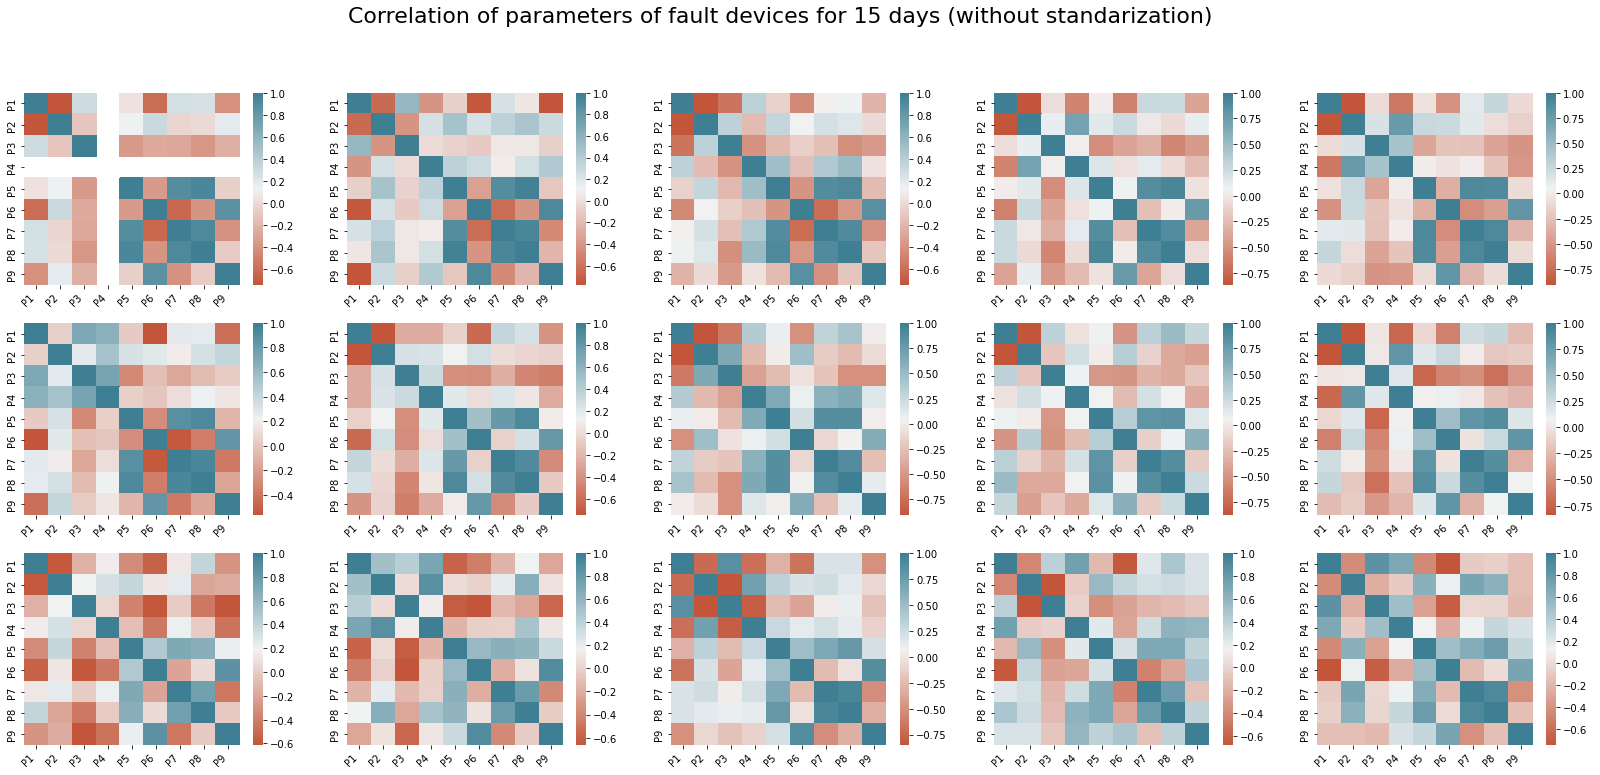

In [ ]:
fig, axes = plt.subplots(3, 5, figsize=(28, 12))
for i in range(15):
  fd_corr = fault_devices[i].iloc[:, 1:].corr()
  ax = sns.heatmap(
      fd_corr, 
      cmap=sns.diverging_palette(20, 220, n=200),
      ax=axes[i//5][i%5]
  )

  ax.set_xticklabels(
      ax.get_xticklabels(),
      rotation=45,
      horizontalalignment='right'
  );
    
fig.suptitle('Correlation of parameters of fault devices for 15 days (without standarization)', fontsize=22)

Text(0.5, 0.98, 'Correlation of parameters of normal devices for 15 days (without standarization)')

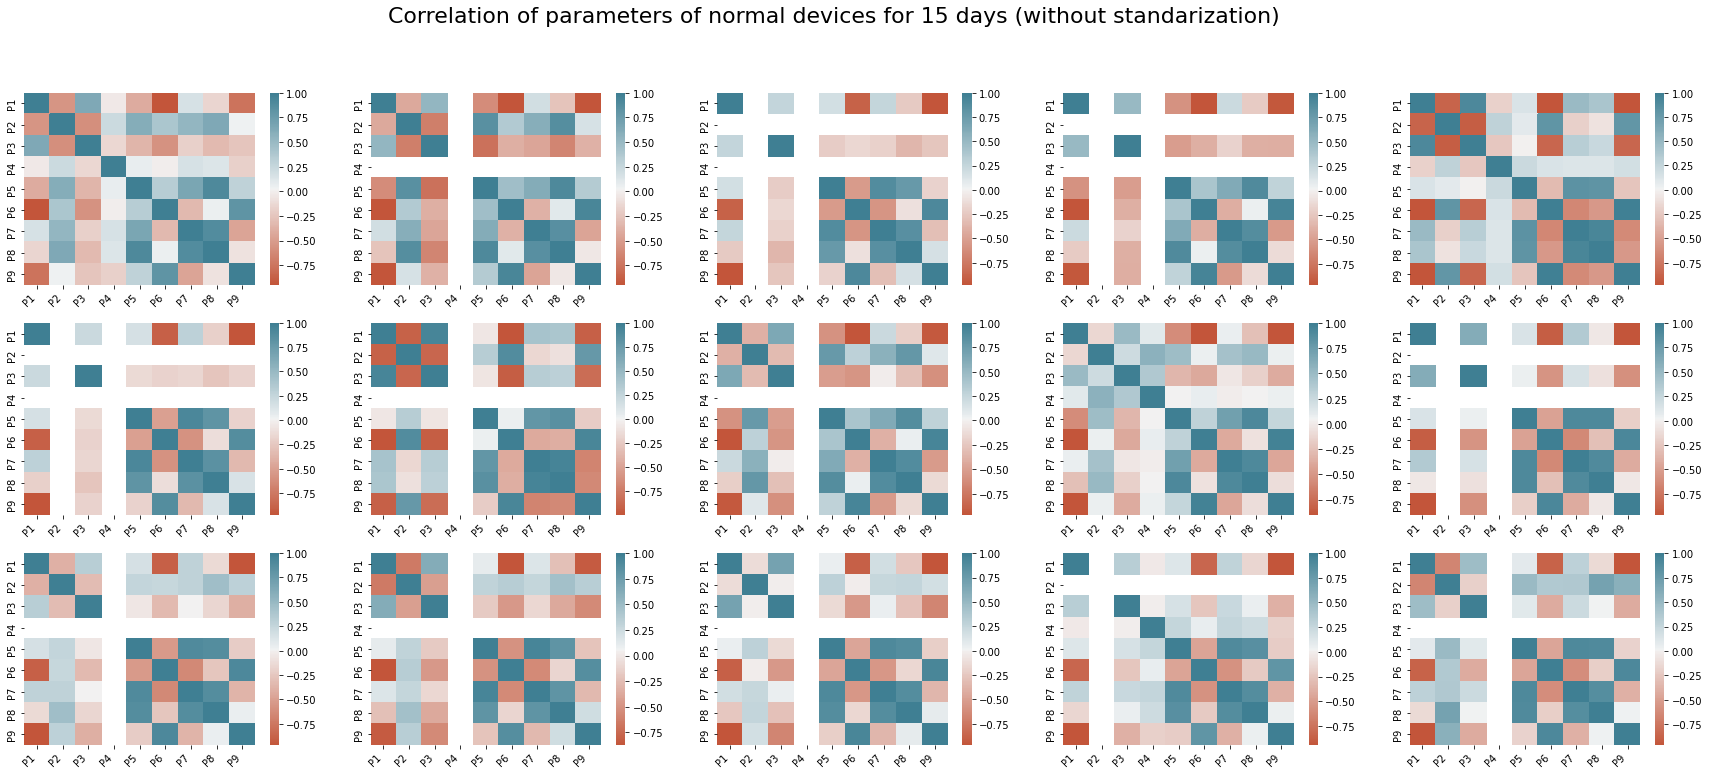

In [ ]:
fig, axes = plt.subplots(3, 5, figsize=(30, 12))
for i in range(15):
  fd_corr = normal_devices[i].iloc[:, 1:].corr()
  ax = sns.heatmap(
      fd_corr, 
      cmap=sns.diverging_palette(20, 220, n=200),
      ax=axes[i//5][i%5]
  )

  ax.set_xticklabels(
      ax.get_xticklabels(),
      rotation=45,
      horizontalalignment='right'
  );
    
fig.suptitle('Correlation of parameters of normal devices for 15 days (without standarization)', fontsize=22)

Otrzymane wykresy nie pozwoliły jednoznacznie stwierdzić, które parametry można by było pominąć. Mimo wysokiej korelacji parametrów w pewnych dniach, wielkość tej korelacji w kolejnych dniach była inna. Dlatego zdecydowaliśmy się przy trenowaniu i testowaniu modelu, wziąć pod uwagę wszystkie parametry.

# Analiza danych - ze standaryzacją

### Przygotowanie danych ustandaryzowanych

In [93]:
def normalize_dataframe(series):
  scaler = MinMaxScaler(feature_range=(0, 9))
  series[['P1','P2', 'P3', 'P4', 'P5', 'P6', 'P7','P8', 'P9']] = scaler.fit_transform(series[['P1','P2', 'P3', 'P4', 'P5', 'P6', 'P7','P8', 'P9']])
  return series

def standarize_dataframe(series):
  scaler = StandardScaler()
  series[['P1','P2', 'P3', 'P4', 'P5', 'P6', 'P7','P8', 'P9']] = scaler.fit_transform(series[['P1','P2', 'P3', 'P4', 'P5', 'P6', 'P7','P8', 'P9']])
  return series

In [94]:
# po tej operacji wartosci mean i std powinny być takie: mean -> bliskie 0, std -> bliskie 1
fault_devices_std = [standarize_dataframe(fault_devices) for fault_devices in fault_devices]
normal_devices_std = [standarize_dataframe(normal_devices) for normal_devices in normal_devices]

# merge features fault + devices without time column
X_std = np.asarray([x.iloc[:, 1:].to_numpy() for x in fault_devices_std] + [x.iloc[:, 1:].to_numpy() for x in normal_devices_std])
# merge output without time column
Y_std = np.hstack((np.full((1,len(fault_devices_std)), 0)[0], np.full((1,len(normal_devices_std)), 1)[0]))
print("Num of fault: ", len(fault_devices_std))
print("Num of normal: ", len(normal_devices_std))
print("Num of all: ", len(X))

Num of fault:  54
Num of normal:  53
Num of all:  107


## Wyresy statystyczne poszczególnych parametrów: średnia, standardowe odchylenie, mediana

In [ ]:
# percentile list
perc =[.20, .40, .60, .80]
  
# list of dtypes to include
include =['object', 'float', 'int']

devices_desc = []
mean = []
std = []
median = []

for fault in fault_devices_std:
  mean.append(fault.describe(percentiles = perc, include = include).loc[['mean']])
  std.append(fault.describe(percentiles = perc, include = include).loc[['std']])
  median_df = pd.DataFrame(fault.median(axis='rows')).transpose()
  median_df.index = ['median']
  median.append(median_df)
  

for normal in normal_devices_std:
  mean.append(normal.describe(percentiles = perc, include = include).loc[['mean']])
  std.append(normal.describe(percentiles = perc, include = include).loc[['std']])
  median_df = pd.DataFrame(normal.median(axis='rows')).transpose()
  median_df.index = ['median']
  median.append(median_df)

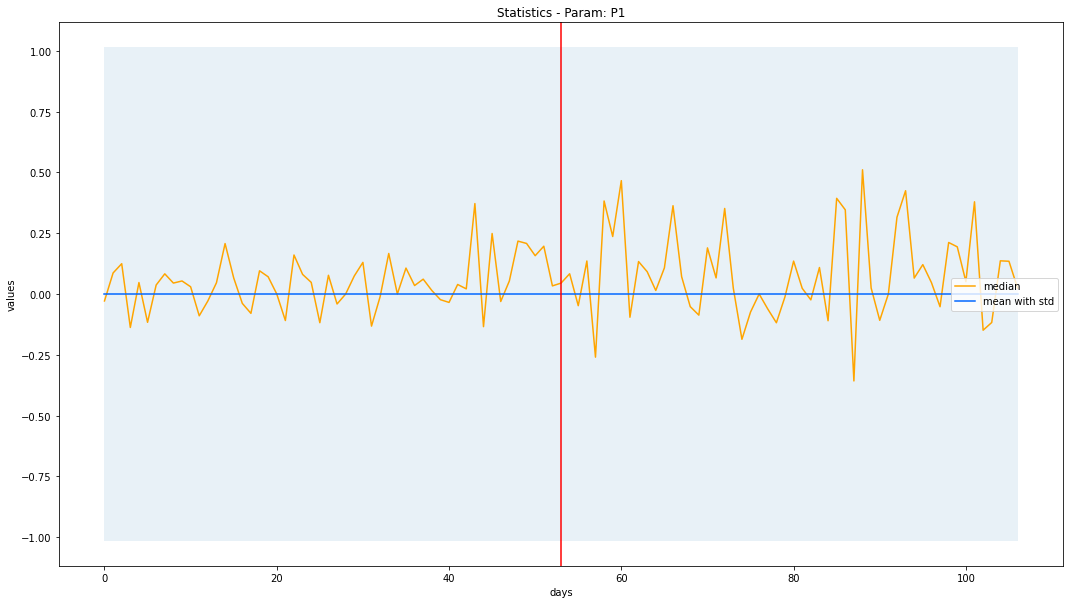

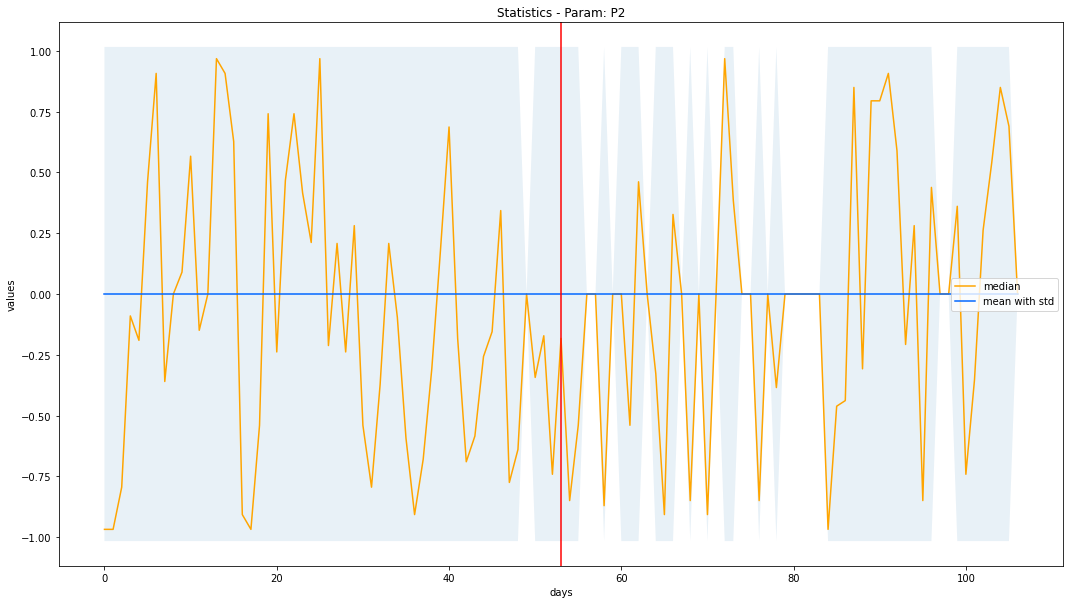

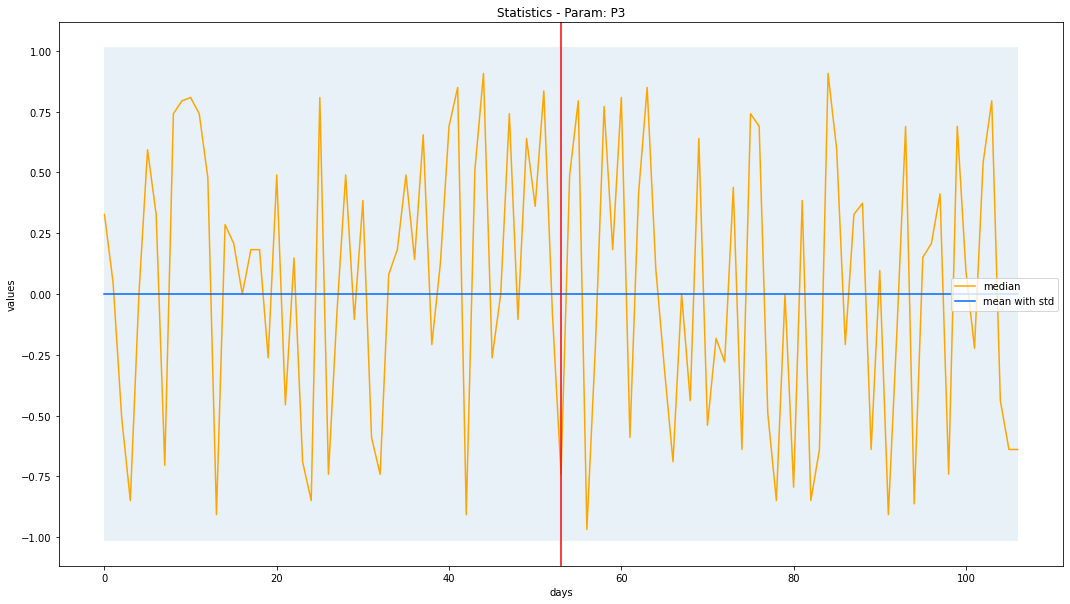

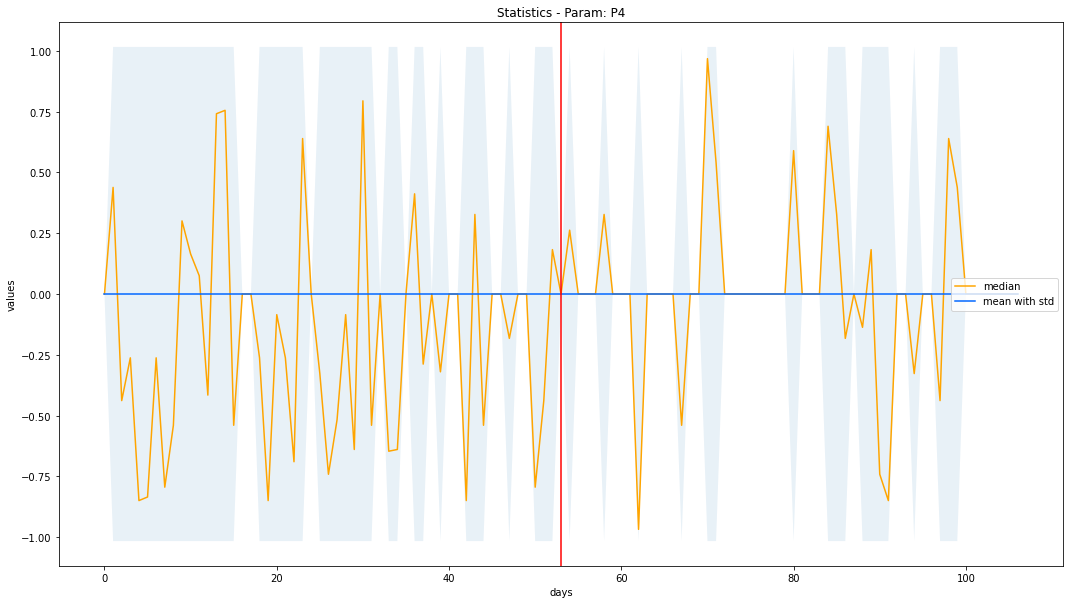

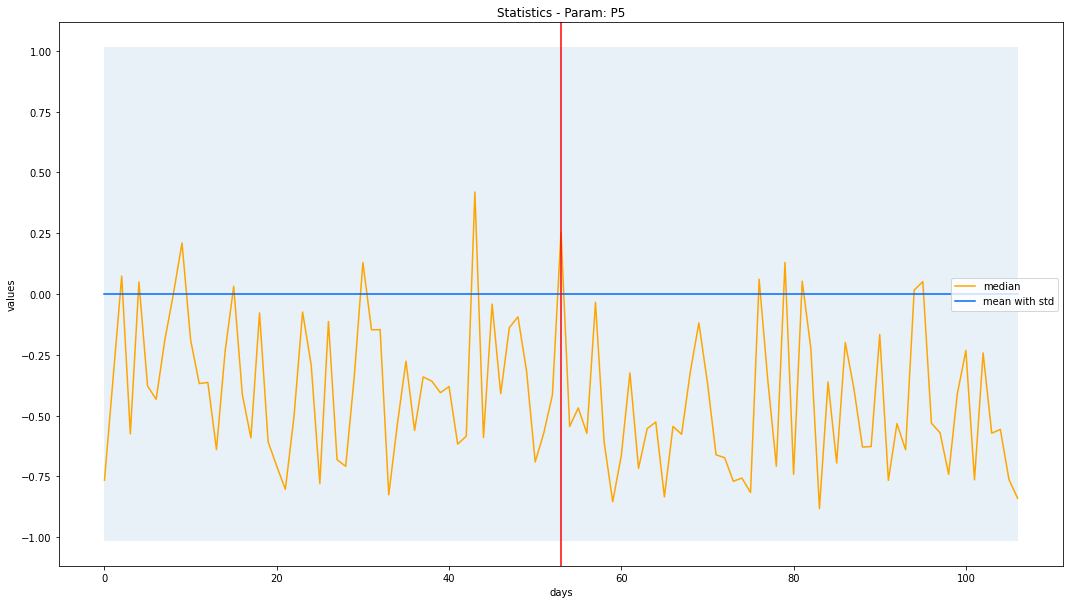

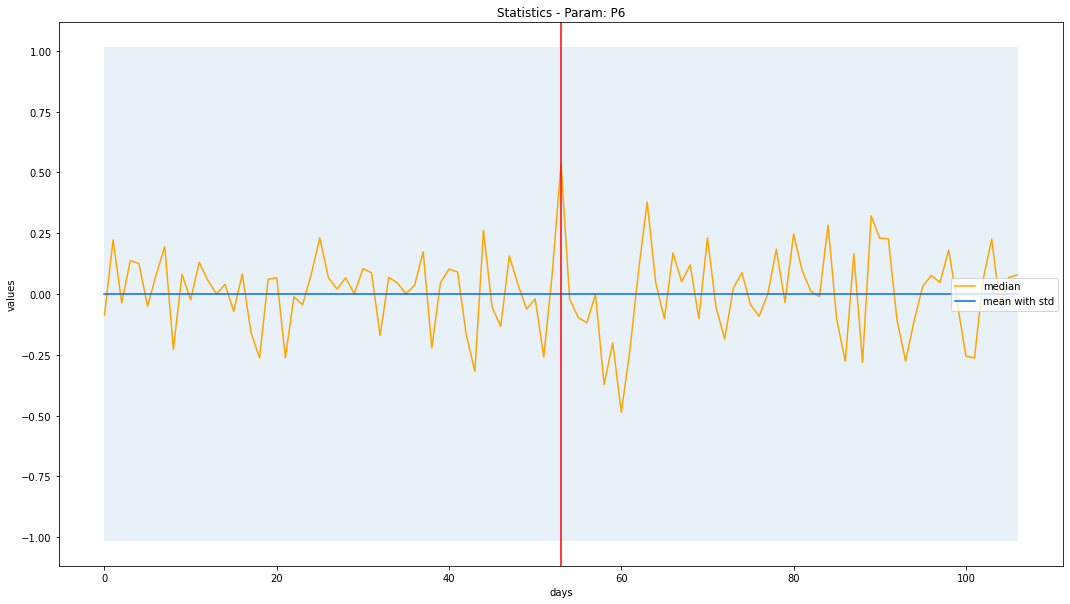

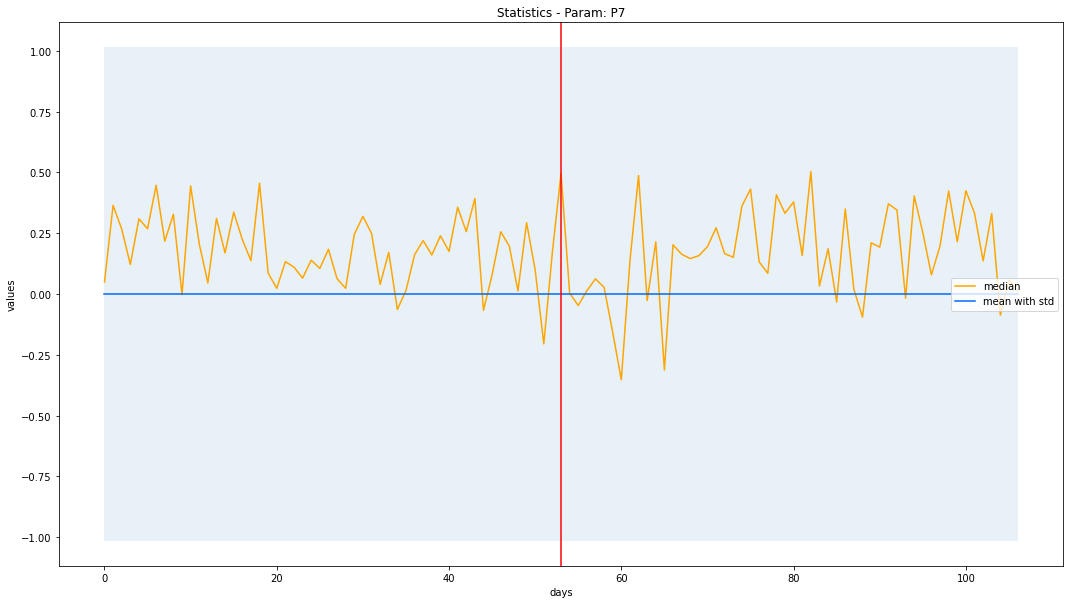

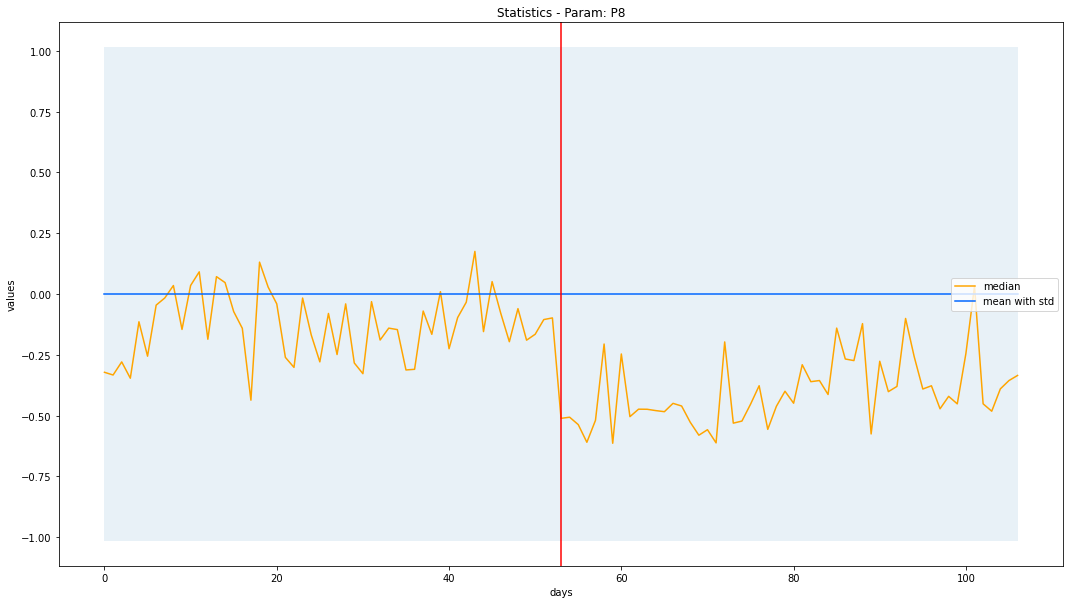

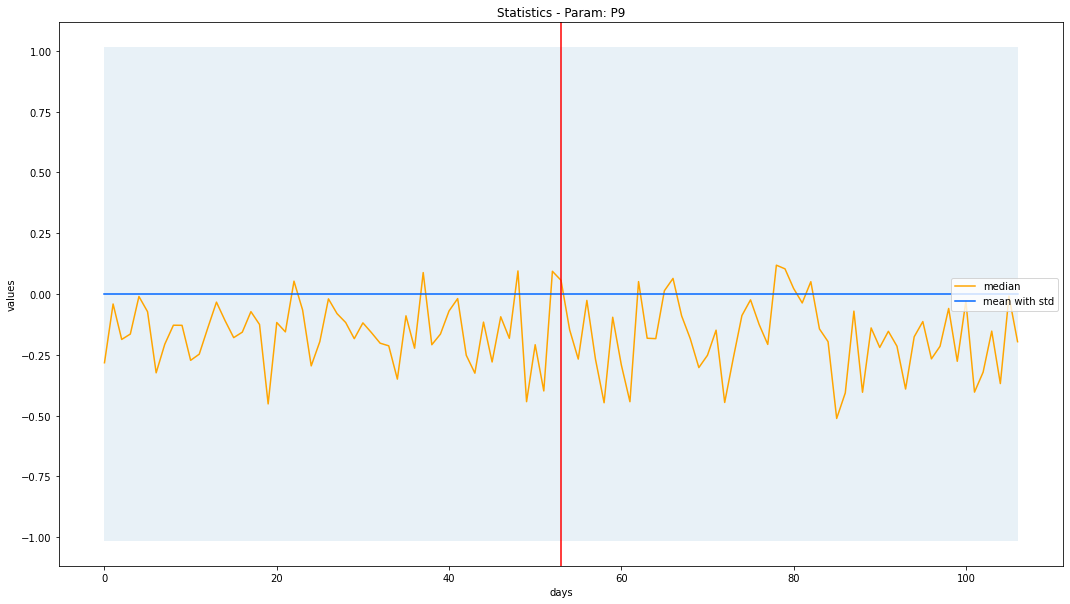

In [ ]:
plt.rcParams["figure.figsize"] = (18,10)
for params in column_names[1:]:
  plt.title("Statistics - Param: " + params)
  p_median = [x[params] for x in median]
  p_mean = [x[params].values.tolist()[0] for x in mean]
  p_std = [x[params].values.tolist()[0] for x in std]
  plt.plot(list(range(0, len(p_median))), p_median, label="median", color="orange")
  plt.plot(list(range(0, len(p_mean))), p_mean, label="mean with std", color="#0066ff")
  plt.fill_between(range(len(p_mean)),np.array(p_mean)-np.array(p_std),np.array(p_mean)+np.array(p_std),alpha=.1)

  plt.axvline(53, color='red')
  plt.xlabel("days")
  plt.ylabel("values")
  plt.legend(loc="center right")
  plt.show()

Zgodnie z założeniami standaryzacji otrzymaliśmy średnią biską 0 oraz odchylenie standardowe równe 1.

## Korelacje parametrów

Text(0.5, 0.98, 'Correlation of parameters of fault devices for 15 days (with standarization)')

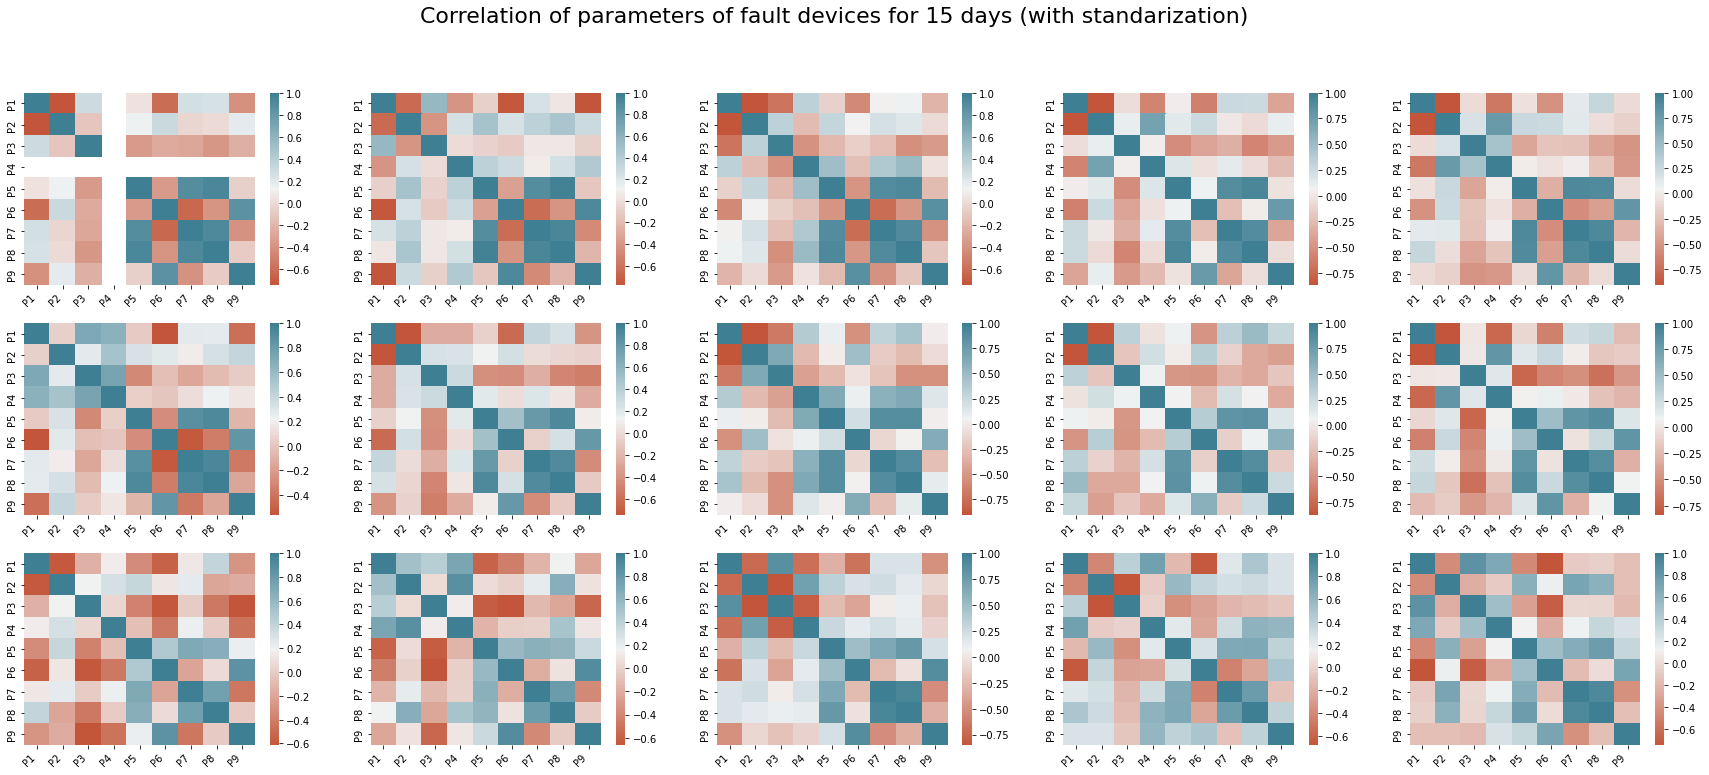

In [ ]:
fig, axes = plt.subplots(3, 5, figsize=(30, 12))
for i in range(15):
  fd_corr = fault_devices_std[i].iloc[:, 1:].corr()
  ax = sns.heatmap(
      fd_corr, 
      cmap=sns.diverging_palette(20, 220, n=200),
      ax=axes[i//5][i%5]
  )

  ax.set_xticklabels(
      ax.get_xticklabels(),
      rotation=45,
      horizontalalignment='right'
  );
    
fig.suptitle('Correlation of parameters of fault devices for 15 days (with standarization)', fontsize=22)

Text(0.5, 0.98, 'Correlation of parameters of normal devices for 15 days (with standarization)')

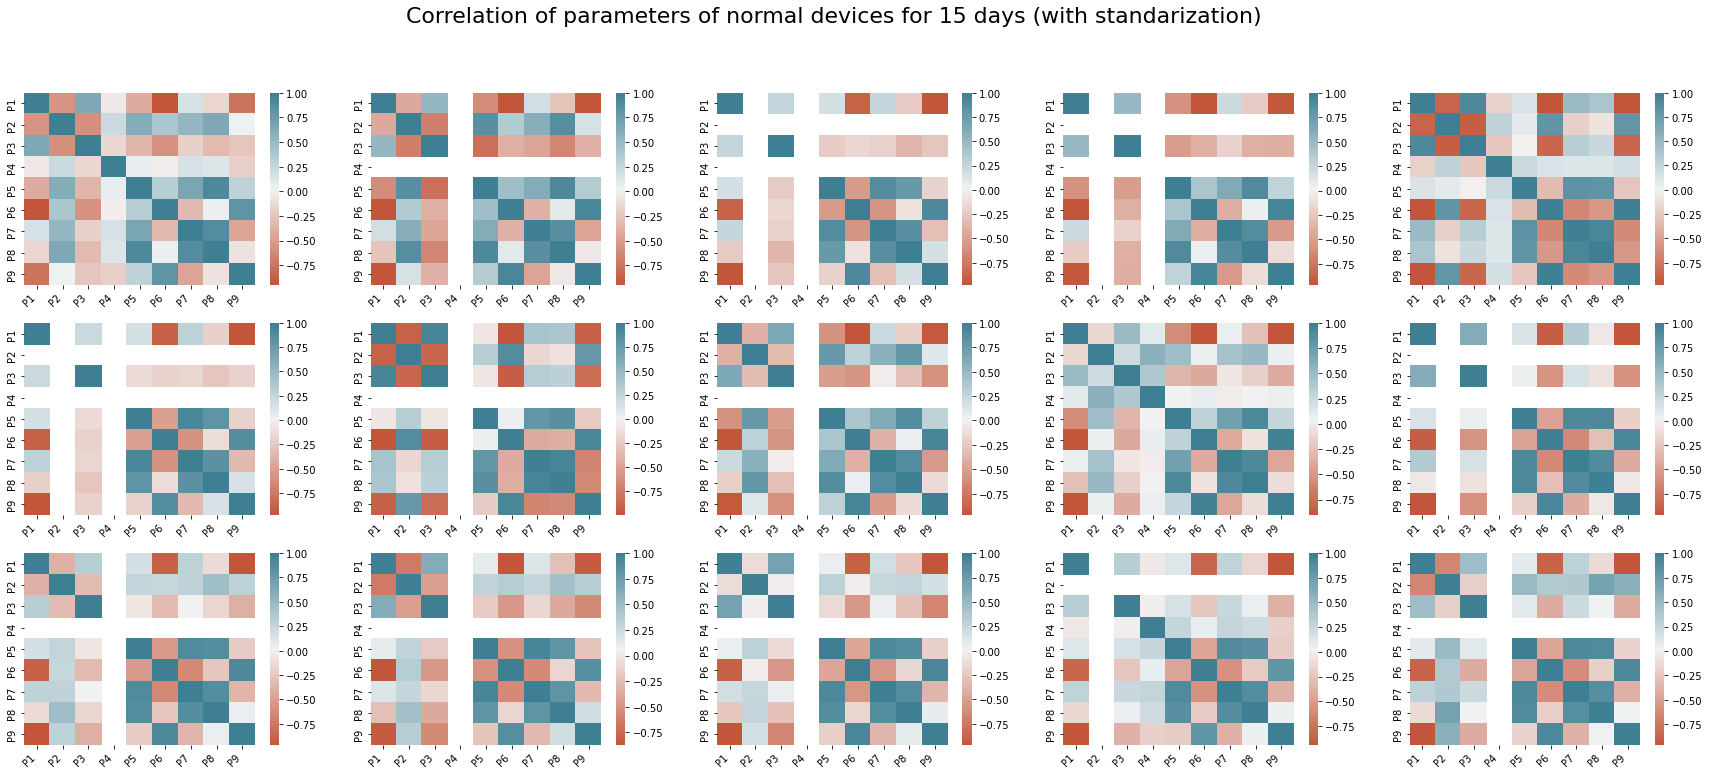

In [ ]:
fig, axes = plt.subplots(3, 5, figsize=(30, 12))
for i in range(15):
  fd_corr = normal_devices_std[i].iloc[:, 1:].corr()
  ax = sns.heatmap(
      fd_corr, 
      cmap=sns.diverging_palette(20, 220, n=200),
      ax=axes[i//5][i%5]
  )

  ax.set_xticklabels(
      ax.get_xticklabels(),
      rotation=45,
      horizontalalignment='right'
  );
    
fig.suptitle('Correlation of parameters of normal devices for 15 days (with standarization)', fontsize=22)

Podobnie jak dla danych nieustandaryzowanych, ze względu na duże różnice korelacji paramtetrów w poszczególnych dniach, nie byliśmy w stanie odrzucić żadnego z parametrów.


# Podzial danych do uczenia i walidacji

In [138]:
from sklearn.model_selection import KFold

# po tej operacji wartosci mean i std powinny być takie: mean -> bliskie 0, std -> bliskie 1
fault_devices_std = [standarize_dataframe(fault_devices) for fault_devices in fault_devices]
normal_devices_std = [standarize_dataframe(normal_devices) for normal_devices in normal_devices]

# merge features fault + devices without time column
X_std = np.asarray([x.iloc[:, 1:].to_numpy() for x in fault_devices_std] + [x.iloc[:, 1:].to_numpy() for x in normal_devices_std])
# merge output without time column
Y_std = np.hstack((np.full((1,len(fault_devices_std)), 0)[0], np.full((1,len(normal_devices_std)), 1)[0]))

# cross validation CV5

kf = KFold(n_splits = 5, shuffle = True, random_state = 9)
train, test = next(kf.split(X_std, Y_std), None)

train_X = np.asarray([X_std[x] for x in train])
train_Y = np.asarray([Y_std[y] for y in train])
vald_X =  np.asarray([X_std[x] for x in test[0:test.shape[0]:2]])
vald_Y =  np.asarray([Y_std[y] for y in test[0:test.shape[0]:2]])
test_X =  np.asarray([X_std[x] for x in test[1:test.shape[0]:2]])
test_Y =  np.asarray([Y_std[y] for y in test[1: test.shape[0]:2]])

# Modele sieci CNN

In [96]:
# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=5,
                           restore_best_weights=True,
                           mode='min')

In [143]:
def create_model(shape=(10,9), hidden_neuron = 50, pool_size = 2, filters = 64, batch_size=None):
  model = Sequential()
  model.add(Conv1D(filters=filters, kernel_size=2, activation='relu', input_shape=shape))
  model.add(MaxPooling1D(pool_size=pool_size))
  model.add(Flatten())
  model.add(Dense(hidden_neuron, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  # model.compile(optimizer='adam', loss=keras.losses.mse, metrics=['accuracy'])
  model.compile(optimizer='adam', loss=keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
  return model

Funkcja wczytująca zapisany model sieci neuronowej.

In [98]:
from keras.models import load_model

def load_model_from_file(filepath):
  model = load_model(filepath)
  return model

Funkcja zwracająca metryki modelu

In [100]:
def get_model_metrics(test_Y, out_Y):
  accuracy = accuracy_score(test_Y, out_Y)
  # precision tp / (tp + fp)
  precision = precision_score(test_Y, out_Y, average=None)
  print('Precision: {}'.format(precision))
  # recall: tp / (tp + fn)
  recall = recall_score(test_Y, out_Y)
  print('Recall: {}'.format(recall))
  # f1: 2 tp / (2 tp + fp + fn)
  f1 = f1_score(test_Y, out_Y)
  print('F1 score: %f' % f1)
  # ROC AUC
  auc = roc_auc_score(test_Y, out_Y)
  print('ROC AUC: %f' % auc)
  return (accuracy, precision, recall, f1, auc)

In [ ]:
model = create_model(shape=(31,9))
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 30, 64)            1216      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 15, 64)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 960)               0         
                                                                 
 dense (Dense)               (None, 50)                48050     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 49,317
Trainable params: 49,317
Non-trainable params: 0
____________________________________________________

### Model bez grupowania

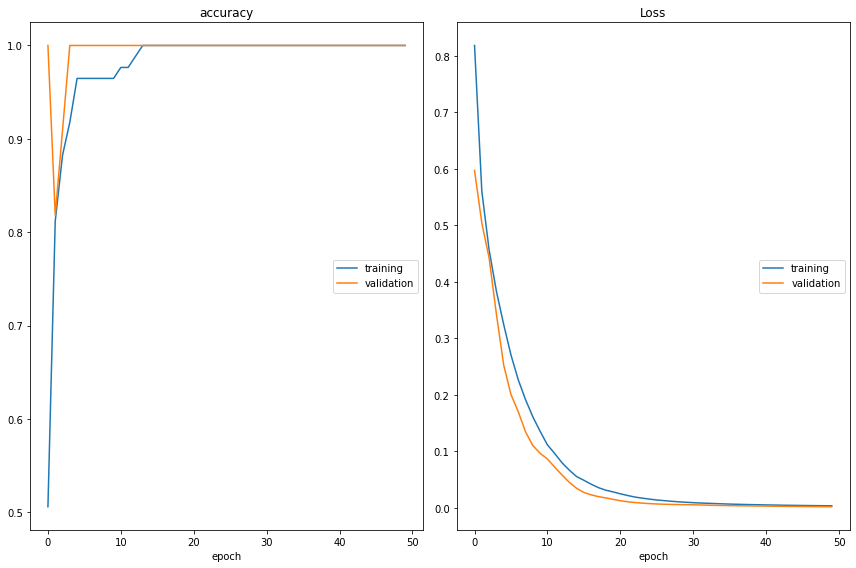

accuracy
	training         	 (min:    0.506, max:    1.000, cur:    1.000)
	validation       	 (min:    0.818, max:    1.000, cur:    1.000)
Loss
	training         	 (min:    0.004, max:    0.819, cur:    0.004)
	validation       	 (min:    0.002, max:    0.597, cur:    0.002)
2/2 [==============================] - 0s 243ms/step - loss: 0.0036 - accuracy: 1.0000 - val_loss: 0.0020 - val_accuracy: 1.0000


In [101]:
model = create_model(shape=(31,9))
model.fit(train_X, train_Y, batch_size=64, epochs=50,
                    validation_data=(test_X, test_Y),
                    callbacks=[PlotLossesKeras(), 
                               early_stop,
                               ModelCheckpoint(filepath=models_path + '/model0.hdf5',save_best_only=True)
                               ])  

C:\Users\Patryk\AppData\Local\Temp\ipykernel_15788\1715442396.py:29: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<Figure size 1296x720 with 0 Axes>

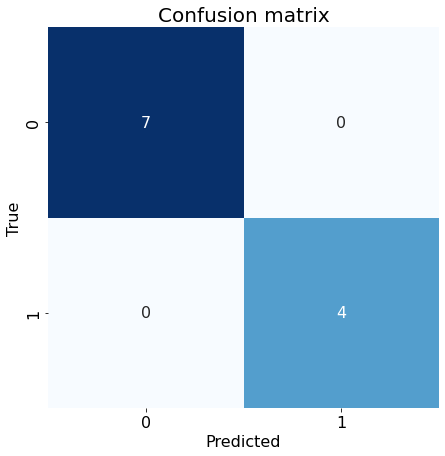

In [102]:
# predictions
# example of loading model
# model = load_model_from_file(models_path + '/model0.hdf5')
out_Y = model.predict(test_X, verbose=0)
out_Y = [0 if x<0.5 else 1 for x in out_Y]
matrix = sklearn.metrics.confusion_matrix(test_Y, out_Y)

plt.figure()

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)

cm = sklearn.metrics.confusion_matrix(test_Y, out_Y)
sns.heatmap(
    cm, 
    annot=True, 
    annot_kws={"size": 16},
    fmt='d', 
    cmap=plt.cm.Blues,
    cbar=False,
    ax=ax
)
ax.set_title("Confusion matrix", fontsize=20)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=16)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)
ax.set_ylabel('True', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)

fig.show()

Otrzymane wyniki pierwszej z utworzonych sieci są na bardzo wysokim poziomie - 95% accuracy w fazie walidacyjnej.

### Model bez grupowania - metryki

In [103]:
metrics = get_model_metrics(test_Y, out_Y)

Precision: [1. 1.]
Recall: 1.0
F1 score: 1.000000
ROC AUC: 1.000000


## Analiza i testowanie różnych długości szeregu czasowego

Jednak chcieliśmy pójść o krok dalej i podzielić dane na coraz to mniejsze szeregi czasowe, aby przeanalizować ile minimalnie potrzebujemy danych na wejściu, by poprawnie sieć poprawnie określała czy urządzenie uległo awarii.

In [104]:
from numpy import array
 
def split_sequence(sequence, n_steps):
	X = []
	for i in range(len(sequence)):
		end_ix = i + n_steps
		if end_ix > len(sequence)-1:
			break
		seq_x= sequence[i:end_ix]
		X.append(seq_x)

	return array(X)

In [105]:
def create_time_seq_data(X, n_steps):
  X_new = []
  Y_new = []
  for i in range(len(X)):
    x_part = split_sequence(X[i], n_steps)
    for j in range(len(x_part)):
      X_new.append(x_part[j])
      if i < 54:
        Y_new.append(0)
      else:
        Y_new.append(1)
        
  return X_new, Y_new  

### Szereg czasowy:10 min

In [110]:
k=10
X_new, Y_new = create_time_seq_data(X_std, n_steps=k)

In [111]:
kf = KFold(n_splits = 5, shuffle = True, random_state = 10)
train, test = next(kf.split(X_new, Y_new), None)

test_l = len(test)
train_X = np.asarray([X_new[x] for x in train])
train_Y = np.asarray([Y_new[y] for y in train])
vald_X =  np.asarray([X_new[x] for x in test[0:test_l:2]])
vald_Y =  np.asarray([Y_new[y] for y in test[0:test_l:2]])
test_X =  np.asarray([X_new[x] for x in test[1:test_l:2]])
test_Y =  np.asarray([Y_new[y] for y in test[1:test_l:2]])

In [112]:
model = create_model(shape=(k,9))
print(model.summary())

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_31 (Conv1D)          (None, 9, 64)             1216      
                                                                 
 max_pooling1d_31 (MaxPoolin  (None, 4, 64)            0         
 g1D)                                                            
                                                                 
 flatten_31 (Flatten)        (None, 256)               0         
                                                                 
 dense_62 (Dense)            (None, 50)                12850     
                                                                 
 dense_63 (Dense)            (None, 1)                 51        
                                                                 
Total params: 14,117
Trainable params: 14,117
Non-trainable params: 0
_________________________________________________

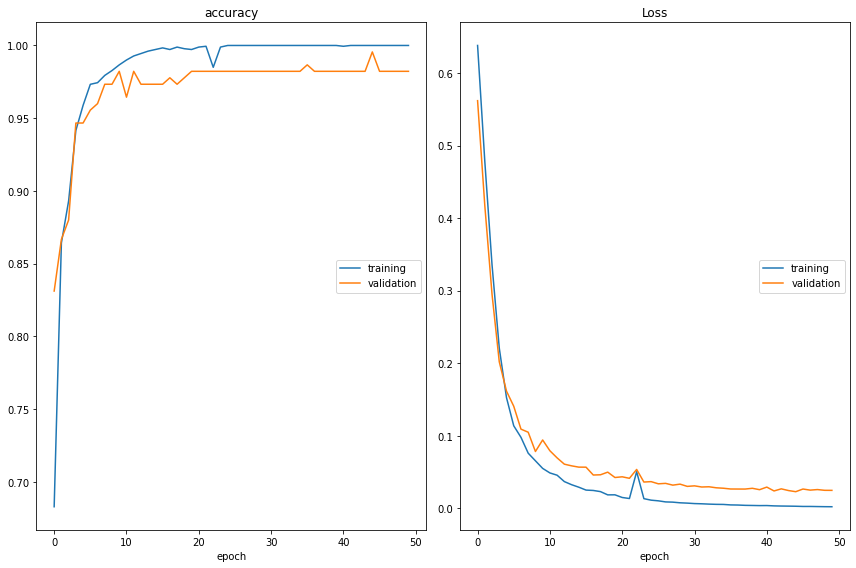

accuracy
	training         	 (min:    0.683, max:    1.000, cur:    1.000)
	validation       	 (min:    0.831, max:    0.996, cur:    0.982)
Loss
	training         	 (min:    0.002, max:    0.638, cur:    0.002)
	validation       	 (min:    0.023, max:    0.562, cur:    0.025)
29/29 [==============================] - 0s 10ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.0247 - val_accuracy: 0.9822


In [113]:
model = create_model(shape=(k,9))
model.fit(train_X, train_Y, batch_size=64, epochs=50,
                    validation_data=(test_X, test_Y),
                    callbacks=[PlotLossesKeras(),
                               early_stop,
                               ModelCheckpoint(filepath=models_path + '/model_10.hdf5',save_best_only=True)
                               ])  

In [114]:
# predition
out_Y_10 = model.predict(test_X, verbose=0)
out_Y_10 = [0 if x<0.5 else 1 for x in out_Y_10]
test_Y_10 = test_Y

### Szereg czasowy: 10min - metryki

In [115]:
metrics = get_model_metrics(test_Y_10, out_Y_10)

Precision: [0.991 1.   ]
Recall: 0.990990990990991
F1 score: 0.995475
ROC AUC: 0.995495


### Szereg czasowy: 5 min

In [116]:
k=5
X_new, Y_new = create_time_seq_data(X_std, n_steps=k)

In [117]:
kf = KFold(n_splits = 5, shuffle = True, random_state = 10)
train, test = next(kf.split(X_new, Y_new), None)

test_l = len(test)
train_X = np.asarray([X_new[x] for x in train])
train_Y = np.asarray([Y_new[y] for y in train])
vald_X =  np.asarray([X_new[x] for x in test[0:test_l:2]])
vald_Y =  np.asarray([Y_new[y] for y in test[0:test_l:2]])
test_X =  np.asarray([X_new[x] for x in test[1:test_l:2]])
test_Y =  np.asarray([Y_new[y] for y in test[1:test_l:2]])

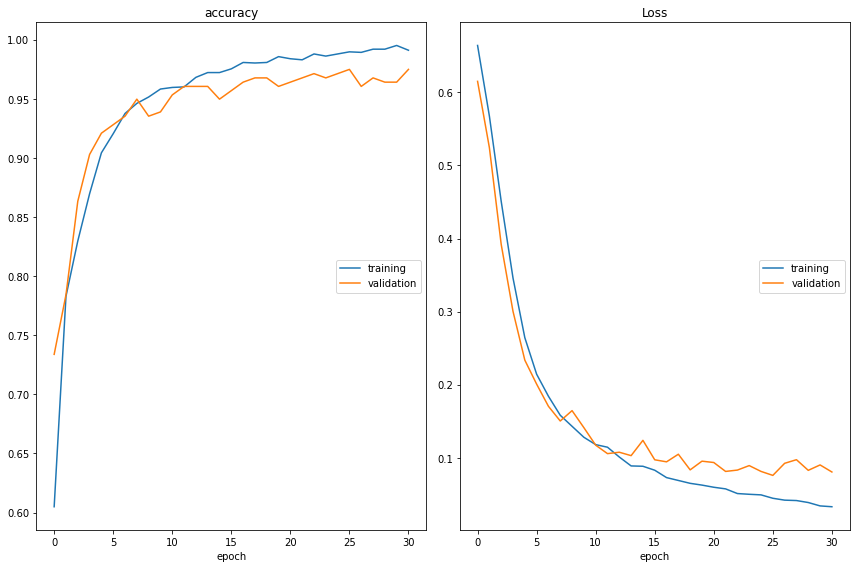

accuracy
	training         	 (min:    0.605, max:    0.995, cur:    0.991)
	validation       	 (min:    0.734, max:    0.975, cur:    0.975)
Loss
	training         	 (min:    0.033, max:    0.664, cur:    0.033)
	validation       	 (min:    0.076, max:    0.615, cur:    0.081)
35/35 [==============================] - 0s 11ms/step - loss: 0.0330 - accuracy: 0.9910 - val_loss: 0.0805 - val_accuracy: 0.9748


In [118]:
model = create_model(shape=(k,9))
model.fit(train_X, train_Y, batch_size=64, epochs=50,
                    validation_data=(test_X, test_Y),
                    callbacks=[PlotLossesKeras(),
                               early_stop,
                               ModelCheckpoint(filepath=models_path + '/model_5.hdf5',save_best_only=True)
                               ])  

In [119]:
# predition
out_Y_5 = model.predict(test_X, verbose=0)
out_Y_5 = [0 if x<0.5 else 1 for x in out_Y_5]
test_Y_5 = test_Y

### Szereg czasowy: 5min - metryki

In [120]:
metrics = get_model_metrics(test_Y_5, out_Y_5)

Precision: [0.979 0.971]
Recall: 0.9779411764705882
F1 score: 0.974359
ROC AUC: 0.974886


### Szereg czasowy: 3 min

In [121]:
k=3
X_new, Y_new = create_time_seq_data(X_std, n_steps=k)

In [122]:
kf = KFold(n_splits = 5, shuffle = True, random_state = 10)
train, test = next(kf.split(X_new, Y_new), None)

test_l = len(test)
train_X = np.asarray([X_new[x] for x in train])
train_Y = np.asarray([Y_new[y] for y in train])
vald_X =  np.asarray([X_new[x] for x in test[0:test_l:2]])
vald_Y =  np.asarray([Y_new[y] for y in test[0:test_l:2]])
test_X =  np.asarray([X_new[x] for x in test[1:test_l:2]])
test_Y =  np.asarray([Y_new[y] for y in test[1:test_l:2]])

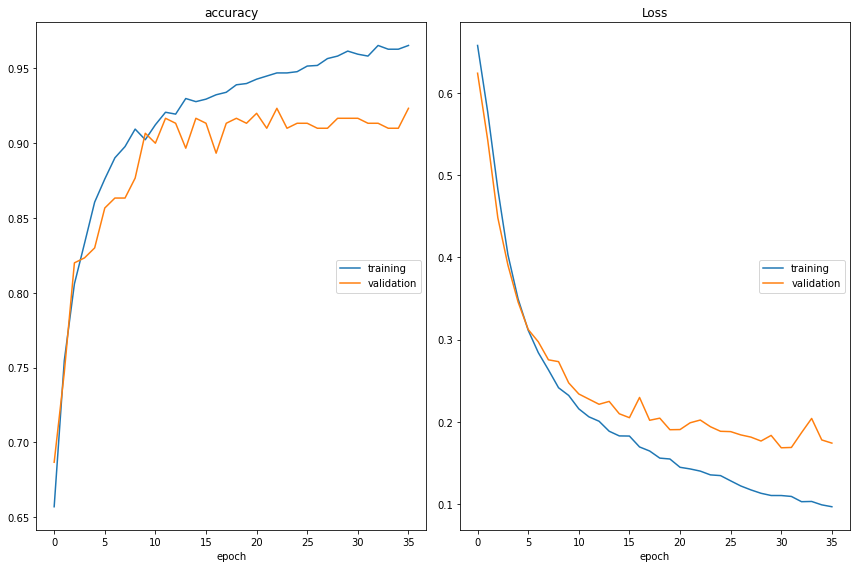

accuracy
	training         	 (min:    0.657, max:    0.965, cur:    0.965)
	validation       	 (min:    0.687, max:    0.923, cur:    0.923)
Loss
	training         	 (min:    0.097, max:    0.658, cur:    0.097)
	validation       	 (min:    0.169, max:    0.624, cur:    0.174)
38/38 [==============================] - 0s 8ms/step - loss: 0.0968 - accuracy: 0.9654 - val_loss: 0.1742 - val_accuracy: 0.9233


In [123]:
model = create_model(shape=(k,9))
model.fit(train_X, train_Y, batch_size=64, epochs=50,
                    validation_data=(test_X, test_Y),
                    callbacks=[PlotLossesKeras(),
                               early_stop,
                               ModelCheckpoint(filepath=models_path + '/model_3.hdf5',save_best_only=True)
                               ])  

In [124]:
# predition
out_Y_3 = model.predict(test_X, verbose=0)
out_Y_3 = [0 if x<0.5 else 1 for x in out_Y_3]
test_Y_3 = test_Y

### Szereg czasowy: 3 min - metryki

In [125]:
metrics = get_model_metrics(test_Y_3, out_Y_3)

Precision: [0.929 0.903]
Recall: 0.9219858156028369
F1 score: 0.912281
ROC AUC: 0.916968


### Porównanie wyników predykcji dla różnych szeregów czasowych (confusion matrix)

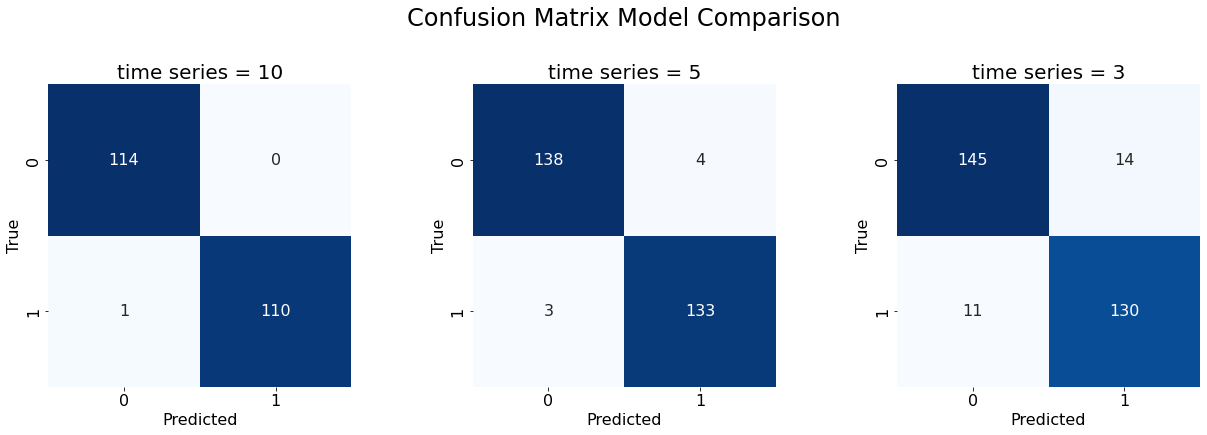

In [126]:
def plot_heatmap(y_true, y_pred, ax, title):
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm, 
        annot=True, 
        annot_kws={"size": 16},
        fmt='d', 
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax
    )
    ax.set_title(title, fontsize=20)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=16)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)
    ax.set_ylabel('True', fontsize=16)
    ax.set_xlabel('Predicted', fontsize=16)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

plot_heatmap(test_Y_10, out_Y_10, ax1, title="time series = 10")    
plot_heatmap(test_Y_5, out_Y_5, ax2, title="time series = 5")    
plot_heatmap(test_Y_3, out_Y_3, ax3, title="time series = 3")   

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9, 
                    top=0.8,
                    wspace=0.4, 
                    hspace=0.4)
 

fig.suptitle("Confusion Matrix Model Comparison", fontsize=24)
plt.show()

# Wnioski

Dla kolejnych szeregów czasowych, tj. 10, 5, 3 min, również udało nam się uzyskać bardzo wysokie wyniki dokładności predykcji sieci:

*  10 min: acc = 0.989
*   5 min: acc = 0.966
*   3 min: acc = 0.937

(Przypomnieniowo: wynik dla danych bez grupowania w szeregi czasowe: acc =  0.955)

Wykorzystując szeregi czasowe, byliśmy w stanie uzyskać wyższe wyniki (acc o 0.03). Zbyt mały szereg czasowy nie daje poprawy wyników, a wręcz go pogarsza.
Podsumowując, spośród danych bez grupowania oraz szeregów czasowych, najlepszy wynik uzyskaliśmy dla szeregu czasowego równego 10 min, otrzymując na danych walidacyjnych prawie 99% dokładności predykcji sieci.

Mimo, że najlepszych wyborem dla problemów predykcji wykorzystujących szeregi czasowe jest RNN i LSTM to jak można wnioskować po uzyskanych przez nas wynikach, dobrym wyborem również może okazać się sieć CNN. Sieć ta przy doborze już kilku warstw daje bardzo wysokie wyniki. 


## Wpływ parametrów na proces uczenia - szereg czasowy 10min

In [127]:
k=10
X_new, Y_new = create_time_seq_data(X_std, n_steps=k)

kf = KFold(n_splits = 5, shuffle = True, random_state = 10)
train, test = next(kf.split(X_new, Y_new), None)

test_l = len(test)
train_X = np.asarray([X_new[x] for x in train])
train_Y = np.asarray([Y_new[y] for y in train])
vald_X =  np.asarray([X_new[x] for x in test[0:test_l:2]])
vald_Y =  np.asarray([Y_new[y] for y in test[0:test_l:2]])
test_X =  np.asarray([X_new[x] for x in test[1:test_l:2]])
test_Y =  np.asarray([Y_new[y] for y in test[1:test_l:2]])

In [128]:
# testowe
num_of_hidden = [x for x in range(1, 60, 5)]
pool_size = [2, 3, 4]
num_of_filters = [16, 32]
batch_size = [4, 8, 16, 32, 64]

##### Batch size

In [129]:
params_per_batch_size = {}

for x in batch_size:
  model = create_model(shape=(k,9), hidden_neuron = 50)
  model.fit(train_X, train_Y, batch_size=x, epochs=60,
                      validation_data=(test_X, test_Y),
                      callbacks=[
                                #  PlotLossesKeras(),
                                 early_stop#,
                                #  ModelCheckpoint(filepath=models_path + '/model_10.hdf5',save_best_only=True)
                                ])
  # predition
  out_Y_10 = model.predict(test_X, verbose=0)
  out_Y_10 = [0 if x<0.5 else 1 for x in out_Y_10]
  test_Y_10 = test_Y
  params_per_batch_size[x] = get_model_metrics(test_Y_10, out_Y_10)

Epoch 1/60
450/450 [==============================] - 1s 2ms/step - loss: 0.3848 - accuracy: 0.8292 - val_loss: 0.1438 - val_accuracy: 0.9422
Epoch 2/60
450/450 [==============================] - 1s 2ms/step - loss: 0.1114 - accuracy: 0.9627 - val_loss: 0.1265 - val_accuracy: 0.9467
Epoch 3/60
450/450 [==============================] - 1s 2ms/step - loss: 0.0642 - accuracy: 0.9772 - val_loss: 0.0553 - val_accuracy: 0.9822
Epoch 4/60
450/450 [==============================] - 1s 2ms/step - loss: 0.0528 - accuracy: 0.9816 - val_loss: 0.0554 - val_accuracy: 0.9778
Epoch 5/60
450/450 [==============================] - 1s 2ms/step - loss: 0.0354 - accuracy: 0.9878 - val_loss: 0.0703 - val_accuracy: 0.9778
Epoch 6/60
450/450 [==============================] - 1s 2ms/step - loss: 0.0247 - accuracy: 0.9922 - val_loss: 0.0379 - val_accuracy: 0.9867
Epoch 7/60
450/450 [==============================] - 1s 2ms/step - loss: 0.0146 - accuracy: 0.9983 - val_loss: 0.0342 - val_accuracy: 0.9867
Epoch 

225/225 [==============================] - 0s 2ms/step - loss: 4.7072e-05 - accuracy: 1.0000 - val_loss: 0.0017 - val_accuracy: 1.0000
Epoch 45/60
225/225 [==============================] - 0s 2ms/step - loss: 3.1109e-05 - accuracy: 1.0000 - val_loss: 0.0014 - val_accuracy: 1.0000
Epoch 46/60
225/225 [==============================] - 0s 2ms/step - loss: 2.6451e-05 - accuracy: 1.0000 - val_loss: 0.0017 - val_accuracy: 1.0000
Epoch 47/60
225/225 [==============================] - 0s 2ms/step - loss: 2.4108e-05 - accuracy: 1.0000 - val_loss: 0.0015 - val_accuracy: 1.0000
Epoch 48/60
225/225 [==============================] - 0s 2ms/step - loss: 2.0955e-05 - accuracy: 1.0000 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 49/60
225/225 [==============================] - 0s 2ms/step - loss: 2.0351e-05 - accuracy: 1.0000 - val_loss: 0.0015 - val_accuracy: 1.0000
Epoch 50/60
225/225 [==============================] - 0s 2ms/step - loss: 1.8827e-05 - accuracy: 1.0000 - val_loss: 0.0016 - val_

57/57 [==============================] - 0s 2ms/step - loss: 0.0072 - accuracy: 1.0000 - val_loss: 0.0352 - val_accuracy: 0.9822
Epoch 23/60
57/57 [==============================] - 0s 2ms/step - loss: 0.0057 - accuracy: 0.9994 - val_loss: 0.0318 - val_accuracy: 0.9867
Epoch 24/60
57/57 [==============================] - 0s 2ms/step - loss: 0.0045 - accuracy: 1.0000 - val_loss: 0.0287 - val_accuracy: 0.9867
Epoch 25/60
57/57 [==============================] - 0s 2ms/step - loss: 0.0046 - accuracy: 1.0000 - val_loss: 0.0308 - val_accuracy: 0.9867
Epoch 26/60
57/57 [==============================] - 0s 2ms/step - loss: 0.0040 - accuracy: 1.0000 - val_loss: 0.0358 - val_accuracy: 0.9867
Epoch 27/60
57/57 [==============================] - 0s 2ms/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 0.0221 - val_accuracy: 0.9867
Epoch 28/60
57/57 [==============================] - 0s 2ms/step - loss: 0.0034 - accuracy: 0.9994 - val_loss: 0.0311 - val_accuracy: 0.9911
Epoch 29/60
57/57 [======

In [130]:
# Print the names of the columns.
print ("{:<10} {:<10} {:<10} {:<10} {:<10} {:<10} {:<10}".format('Batch size', 'Accuracy', 'PPV', 'NPV', 'RECALL', 'F1 Score', 'ROC'))
 
# print each data item.
for key, value in params_per_batch_size.items():
    Accuracy, PPV_NPV, RECALL, F1Score, ROC = value
    print ("{:<10.0f} {:<10.3f} {:<10.3f} {:<10.3f} {:<10.3f} {:<10.3f} {:<10.3f}".format(key, Accuracy, PPV_NPV[0], PPV_NPV[1], RECALL, F1Score, ROC))


Batch size Accuracy   PPV        NPV        RECALL     F1 Score   ROC       
4          0.987      0.991      0.982      0.991      0.987      0.987     
8          1.000      1.000      1.000      1.000      1.000      1.000     
16         0.996      0.991      1.000      0.991      0.995      0.995     
32         0.987      0.991      0.982      0.991      0.987      0.987     
64         0.987      0.991      0.982      0.991      0.987      0.987     


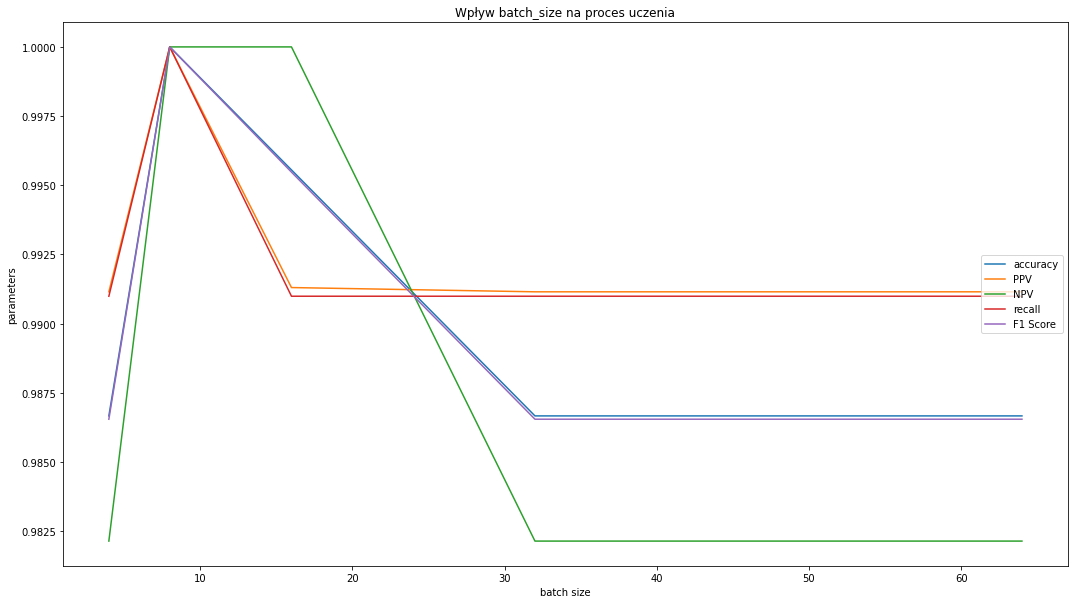

In [131]:
plt.rcParams["figure.figsize"] = (18,10)
plt.title("Wpływ batch_size na proces uczenia")
plt.plot(batch_size, [params_per_batch_size[x][0] for x in params_per_batch_size.keys()], label="accuracy")
plt.plot(batch_size, [params_per_batch_size[x][1][0] for x in params_per_batch_size.keys()], label="PPV")
plt.plot(batch_size, [params_per_batch_size[x][1][1] for x in params_per_batch_size.keys()], label="NPV")
plt.plot(batch_size, [params_per_batch_size[x][2] for x in params_per_batch_size.keys()], label="recall")
plt.plot(batch_size, [params_per_batch_size[x][3] for x in params_per_batch_size.keys()], label="F1 Score")
# plt.plot(batch_size, [params_per_batch_size[x][4] for x in params_per_batch_size.keys()], label="ROC")

plt.xlabel("batch size")
plt.ylabel("parameters")
plt.legend(loc="center right")
# plt.xscale('log')
plt.show()

##### Hidden neurons

In [132]:
params_per_num_of_hidden = {}

for x in num_of_hidden:
  model = create_model(shape=(k,9), hidden_neuron = x)
  model.fit(train_X, train_Y, batch_size=64, epochs=60,
                      validation_data=(test_X, test_Y),
                      callbacks=[
                                #  PlotLossesKeras(),
                                early_stop#,
                                #  ModelCheckpoint(filepath=models_path + '/model_10.hdf5',save_best_only=True)
                                ])
  # predition
  out_Y_10 = model.predict(test_X, verbose=0)
  out_Y_10 = [0 if x<0.5 else 1 for x in out_Y_10]
  test_Y_10 = test_Y
  params_per_num_of_hidden[x] = get_model_metrics(test_Y_10, out_Y_10)

Epoch 1/60
29/29 [==============================] - 1s 7ms/step - loss: 0.6850 - accuracy: 0.5281 - val_loss: 0.6705 - val_accuracy: 0.5733
Epoch 2/60
29/29 [==============================] - 0s 3ms/step - loss: 0.6442 - accuracy: 0.6060 - val_loss: 0.6375 - val_accuracy: 0.6000
Epoch 3/60
29/29 [==============================] - 0s 3ms/step - loss: 0.6061 - accuracy: 0.6583 - val_loss: 0.6065 - val_accuracy: 0.6222
Epoch 4/60
29/29 [==============================] - 0s 3ms/step - loss: 0.5829 - accuracy: 0.6795 - val_loss: 0.5849 - val_accuracy: 0.6622
Epoch 5/60
29/29 [==============================] - 0s 3ms/step - loss: 0.5603 - accuracy: 0.7129 - val_loss: 0.5667 - val_accuracy: 0.6978
Epoch 6/60
29/29 [==============================] - 0s 3ms/step - loss: 0.5381 - accuracy: 0.7379 - val_loss: 0.5383 - val_accuracy: 0.7733
Epoch 7/60
29/29 [==============================] - 0s 3ms/step - loss: 0.5094 - accuracy: 0.7963 - val_loss: 0.4944 - val_accuracy: 0.8133
Epoch 8/60
29/29 [==

29/29 [==============================] - 0s 3ms/step - loss: 0.1040 - accuracy: 0.9994 - val_loss: 0.1334 - val_accuracy: 0.9822
Epoch 60/60
29/29 [==============================] - 0s 3ms/step - loss: 0.1018 - accuracy: 0.9994 - val_loss: 0.1295 - val_accuracy: 0.9867
Precision: [0.983 0.991]
Recall: 0.9819819819819819
F1 score: 0.986425
ROC AUC: 0.986605
Epoch 1/60
29/29 [==============================] - 1s 6ms/step - loss: 0.6549 - accuracy: 0.5949 - val_loss: 0.6065 - val_accuracy: 0.7067
Epoch 2/60
29/29 [==============================] - 0s 3ms/step - loss: 0.5635 - accuracy: 0.7629 - val_loss: 0.5233 - val_accuracy: 0.8044
Epoch 3/60
29/29 [==============================] - 0s 3ms/step - loss: 0.4664 - accuracy: 0.8397 - val_loss: 0.4300 - val_accuracy: 0.8711
Epoch 4/60
29/29 [==============================] - 0s 3ms/step - loss: 0.3773 - accuracy: 0.8876 - val_loss: 0.3455 - val_accuracy: 0.8889
Epoch 5/60
29/29 [==============================] - 0s 3ms/step - loss: 0.2978 - 

29/29 [==============================] - 0s 3ms/step - loss: 0.0053 - accuracy: 0.9994 - val_loss: 0.0239 - val_accuracy: 0.9911
Epoch 57/60
29/29 [==============================] - 0s 3ms/step - loss: 0.0051 - accuracy: 0.9994 - val_loss: 0.0225 - val_accuracy: 0.9911
Epoch 58/60
29/29 [==============================] - 0s 3ms/step - loss: 0.0057 - accuracy: 0.9994 - val_loss: 0.0252 - val_accuracy: 0.9822
Epoch 59/60
29/29 [==============================] - 0s 3ms/step - loss: 0.0048 - accuracy: 1.0000 - val_loss: 0.0230 - val_accuracy: 0.9956
Epoch 60/60
29/29 [==============================] - 0s 3ms/step - loss: 0.0046 - accuracy: 1.0000 - val_loss: 0.0229 - val_accuracy: 0.9867
Precision: [0.991 0.982]
Recall: 0.990990990990991
F1 score: 0.986547
ROC AUC: 0.986724
Epoch 1/60
29/29 [==============================] - 1s 7ms/step - loss: 0.6716 - accuracy: 0.5993 - val_loss: 0.6290 - val_accuracy: 0.7378
Epoch 2/60
29/29 [==============================] - 0s 3ms/step - loss: 0.5877 

29/29 [==============================] - 0s 3ms/step - loss: 0.2335 - accuracy: 0.9410 - val_loss: 0.2010 - val_accuracy: 0.9511
Epoch 6/60
29/29 [==============================] - 0s 5ms/step - loss: 0.1613 - accuracy: 0.9605 - val_loss: 0.1590 - val_accuracy: 0.9467
Epoch 7/60
29/29 [==============================] - 0s 4ms/step - loss: 0.1261 - accuracy: 0.9688 - val_loss: 0.1247 - val_accuracy: 0.9733
Epoch 8/60
29/29 [==============================] - 0s 3ms/step - loss: 0.1033 - accuracy: 0.9766 - val_loss: 0.1043 - val_accuracy: 0.9689
Epoch 9/60
29/29 [==============================] - 0s 5ms/step - loss: 0.0846 - accuracy: 0.9755 - val_loss: 0.0943 - val_accuracy: 0.9689
Epoch 10/60
29/29 [==============================] - 0s 4ms/step - loss: 0.0714 - accuracy: 0.9811 - val_loss: 0.0831 - val_accuracy: 0.9733
Epoch 11/60
29/29 [==============================] - 0s 3ms/step - loss: 0.0649 - accuracy: 0.9866 - val_loss: 0.0766 - val_accuracy: 0.9733
Epoch 12/60
29/29 [==========

29/29 [==============================] - 0s 3ms/step - loss: 0.0292 - accuracy: 0.9961 - val_loss: 0.0510 - val_accuracy: 0.9822
Epoch 20/60
29/29 [==============================] - 0s 3ms/step - loss: 0.0301 - accuracy: 0.9944 - val_loss: 0.0521 - val_accuracy: 0.9822
Epoch 21/60
29/29 [==============================] - 0s 3ms/step - loss: 0.0294 - accuracy: 0.9950 - val_loss: 0.0516 - val_accuracy: 0.9822
Epoch 22/60
29/29 [==============================] - 0s 3ms/step - loss: 0.0227 - accuracy: 0.9983 - val_loss: 0.0497 - val_accuracy: 0.9822
Epoch 23/60
29/29 [==============================] - 0s 3ms/step - loss: 0.0206 - accuracy: 0.9978 - val_loss: 0.0446 - val_accuracy: 0.9822
Epoch 24/60
29/29 [==============================] - 0s 3ms/step - loss: 0.0189 - accuracy: 0.9978 - val_loss: 0.0452 - val_accuracy: 0.9822
Epoch 25/60
29/29 [==============================] - 0s 3ms/step - loss: 0.0177 - accuracy: 0.9978 - val_loss: 0.0434 - val_accuracy: 0.9822
Epoch 26/60
29/29 [======

29/29 [==============================] - 0s 3ms/step - loss: 0.0222 - accuracy: 0.9983 - val_loss: 0.0414 - val_accuracy: 0.9867
Epoch 21/60
29/29 [==============================] - 0s 3ms/step - loss: 0.0193 - accuracy: 0.9989 - val_loss: 0.0392 - val_accuracy: 0.9822
Epoch 22/60
29/29 [==============================] - 0s 3ms/step - loss: 0.0186 - accuracy: 0.9983 - val_loss: 0.0382 - val_accuracy: 0.9867
Epoch 23/60
29/29 [==============================] - 0s 3ms/step - loss: 0.0165 - accuracy: 0.9989 - val_loss: 0.0355 - val_accuracy: 0.9867
Epoch 24/60
29/29 [==============================] - 0s 3ms/step - loss: 0.0146 - accuracy: 0.9994 - val_loss: 0.0342 - val_accuracy: 0.9867
Epoch 25/60
29/29 [==============================] - 0s 3ms/step - loss: 0.0135 - accuracy: 0.9994 - val_loss: 0.0329 - val_accuracy: 0.9867
Epoch 26/60
29/29 [==============================] - 0s 3ms/step - loss: 0.0131 - accuracy: 0.9994 - val_loss: 0.0304 - val_accuracy: 0.9911
Epoch 27/60
29/29 [======

29/29 [==============================] - 0s 3ms/step - loss: 0.0270 - accuracy: 0.9978 - val_loss: 0.0484 - val_accuracy: 0.9822
Epoch 18/60
29/29 [==============================] - 0s 3ms/step - loss: 0.0250 - accuracy: 0.9972 - val_loss: 0.0478 - val_accuracy: 0.9733
Epoch 19/60
29/29 [==============================] - 0s 3ms/step - loss: 0.0263 - accuracy: 0.9972 - val_loss: 0.0462 - val_accuracy: 0.9778
Epoch 20/60
29/29 [==============================] - 0s 3ms/step - loss: 0.0227 - accuracy: 0.9978 - val_loss: 0.0494 - val_accuracy: 0.9778
Epoch 21/60
29/29 [==============================] - 0s 3ms/step - loss: 0.0207 - accuracy: 0.9983 - val_loss: 0.0454 - val_accuracy: 0.9867
Epoch 22/60
29/29 [==============================] - 0s 3ms/step - loss: 0.0173 - accuracy: 0.9989 - val_loss: 0.0410 - val_accuracy: 0.9778
Epoch 23/60
29/29 [==============================] - 0s 3ms/step - loss: 0.0182 - accuracy: 0.9978 - val_loss: 0.0414 - val_accuracy: 0.9867
Epoch 24/60
29/29 [======

29/29 [==============================] - 0s 3ms/step - loss: 0.2976 - accuracy: 0.9110 - val_loss: 0.2525 - val_accuracy: 0.9333
Epoch 5/60
29/29 [==============================] - 0s 3ms/step - loss: 0.2104 - accuracy: 0.9416 - val_loss: 0.1770 - val_accuracy: 0.9556
Epoch 6/60
29/29 [==============================] - 0s 3ms/step - loss: 0.1536 - accuracy: 0.9610 - val_loss: 0.1429 - val_accuracy: 0.9644
Epoch 7/60
29/29 [==============================] - 0s 3ms/step - loss: 0.1189 - accuracy: 0.9683 - val_loss: 0.1206 - val_accuracy: 0.9600
Epoch 8/60
29/29 [==============================] - 0s 3ms/step - loss: 0.0985 - accuracy: 0.9711 - val_loss: 0.0959 - val_accuracy: 0.9733
Epoch 9/60
29/29 [==============================] - 0s 3ms/step - loss: 0.0792 - accuracy: 0.9794 - val_loss: 0.0867 - val_accuracy: 0.9644
Epoch 10/60
29/29 [==============================] - 0s 3ms/step - loss: 0.0698 - accuracy: 0.9811 - val_loss: 0.0806 - val_accuracy: 0.9689
Epoch 11/60
29/29 [===========

Epoch 12/60
29/29 [==============================] - 0s 3ms/step - loss: 0.0389 - accuracy: 0.9928 - val_loss: 0.0586 - val_accuracy: 0.9778
Epoch 13/60
29/29 [==============================] - 0s 4ms/step - loss: 0.0334 - accuracy: 0.9933 - val_loss: 0.0694 - val_accuracy: 0.9733
Epoch 14/60
29/29 [==============================] - 0s 4ms/step - loss: 0.0291 - accuracy: 0.9961 - val_loss: 0.0521 - val_accuracy: 0.9733
Epoch 15/60
29/29 [==============================] - 0s 3ms/step - loss: 0.0265 - accuracy: 0.9950 - val_loss: 0.0634 - val_accuracy: 0.9689
Epoch 16/60
29/29 [==============================] - 0s 5ms/step - loss: 0.0245 - accuracy: 0.9983 - val_loss: 0.0554 - val_accuracy: 0.9778
Epoch 17/60
29/29 [==============================] - 0s 4ms/step - loss: 0.0213 - accuracy: 0.9978 - val_loss: 0.0519 - val_accuracy: 0.9822
Epoch 18/60
29/29 [==============================] - 0s 3ms/step - loss: 0.0187 - accuracy: 0.9978 - val_loss: 0.0464 - val_accuracy: 0.9733
Epoch 19/60
2

29/29 [==============================] - 0s 3ms/step - loss: 0.0121 - accuracy: 0.9989 - val_loss: 0.0374 - val_accuracy: 0.9822
Epoch 26/60
29/29 [==============================] - 0s 3ms/step - loss: 0.0110 - accuracy: 0.9994 - val_loss: 0.0324 - val_accuracy: 0.9822
Epoch 27/60
29/29 [==============================] - 0s 3ms/step - loss: 0.0129 - accuracy: 0.9989 - val_loss: 0.0336 - val_accuracy: 0.9822
Epoch 28/60
29/29 [==============================] - 0s 3ms/step - loss: 0.0091 - accuracy: 0.9994 - val_loss: 0.0350 - val_accuracy: 0.9822
Epoch 29/60
29/29 [==============================] - 0s 3ms/step - loss: 0.0084 - accuracy: 1.0000 - val_loss: 0.0372 - val_accuracy: 0.9822
Epoch 30/60
29/29 [==============================] - 0s 3ms/step - loss: 0.0080 - accuracy: 0.9994 - val_loss: 0.0327 - val_accuracy: 0.9822
Epoch 31/60
29/29 [==============================] - 0s 3ms/step - loss: 0.0071 - accuracy: 1.0000 - val_loss: 0.0308 - val_accuracy: 0.9822
Epoch 32/60
29/29 [======

29/29 [==============================] - 0s 3ms/step - loss: 0.0085 - accuracy: 0.9994 - val_loss: 0.0307 - val_accuracy: 0.9822
Epoch 28/60
29/29 [==============================] - 0s 3ms/step - loss: 0.0081 - accuracy: 0.9994 - val_loss: 0.0282 - val_accuracy: 0.9822
Epoch 29/60
29/29 [==============================] - 0s 3ms/step - loss: 0.0072 - accuracy: 1.0000 - val_loss: 0.0344 - val_accuracy: 0.9822
Epoch 30/60
29/29 [==============================] - 0s 3ms/step - loss: 0.0068 - accuracy: 0.9994 - val_loss: 0.0254 - val_accuracy: 0.9867
Epoch 31/60
29/29 [==============================] - 0s 3ms/step - loss: 0.0059 - accuracy: 1.0000 - val_loss: 0.0343 - val_accuracy: 0.9822
Epoch 32/60
29/29 [==============================] - 0s 3ms/step - loss: 0.0060 - accuracy: 0.9994 - val_loss: 0.0254 - val_accuracy: 0.9911
Epoch 33/60
29/29 [==============================] - 0s 3ms/step - loss: 0.0054 - accuracy: 0.9994 - val_loss: 0.0285 - val_accuracy: 0.9867
Epoch 34/60
29/29 [======

In [133]:
# Print the names of the columns.
print ("{:<10} {:<10} {:<10} {:<10} {:<10} {:<10} {:<10}".format('Neurons', 'Accuracy', 'PPV', 'NPV', 'RECALL', 'F1 Score', 'ROC'))
 
# print each data item.
for key, value in params_per_num_of_hidden.items():
    Accuracy, PPV_NPV, RECALL, F1Score, ROC = value
    print ("{:<10.0f} {:<10.3f} {:<10.3f} {:<10.3f} {:<10.3f} {:<10.3f} {:<10.3f}".format(key, Accuracy, PPV_NPV[0], PPV_NPV[1], RECALL, F1Score, ROC))


Neurons    Accuracy   PPV        NPV        RECALL     F1 Score   ROC       
1          0.987      0.983      0.991      0.982      0.986      0.987     
6          0.987      0.991      0.982      0.991      0.987      0.987     
11         0.996      0.991      1.000      0.991      0.995      0.995     
16         0.991      0.991      0.991      0.991      0.991      0.991     
21         0.982      0.991      0.973      0.991      0.982      0.982     
26         0.996      0.991      1.000      0.991      0.995      0.995     
31         0.991      0.991      0.991      0.991      0.991      0.991     
36         0.978      0.991      0.965      0.991      0.978      0.978     
41         0.996      1.000      0.991      1.000      0.996      0.996     
46         0.987      0.991      0.982      0.991      0.987      0.987     
51         0.987      0.983      0.991      0.982      0.986      0.987     
56         0.991      0.991      0.991      0.991      0.991      0.991     

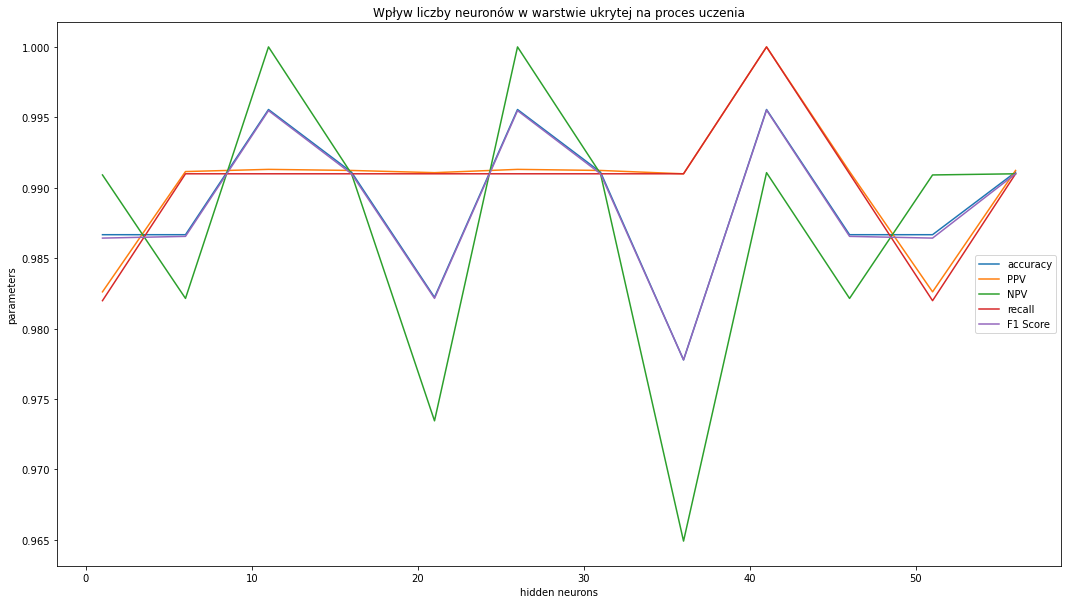

In [134]:
plt.rcParams["figure.figsize"] = (18,10)
plt.title("Wpływ liczby neuronów w warstwie ukrytej na proces uczenia")
plt.plot(num_of_hidden, [params_per_num_of_hidden[x][0] for x in params_per_num_of_hidden.keys()], label="accuracy")
plt.plot(num_of_hidden, [params_per_num_of_hidden[x][1][0] for x in params_per_num_of_hidden.keys()], label="PPV")
plt.plot(num_of_hidden, [params_per_num_of_hidden[x][1][1] for x in params_per_num_of_hidden.keys()], label="NPV")
plt.plot(num_of_hidden, [params_per_num_of_hidden[x][2] for x in params_per_num_of_hidden.keys()], label="recall")
plt.plot(num_of_hidden, [params_per_num_of_hidden[x][3] for x in params_per_num_of_hidden.keys()], label="F1 Score")
# plt.plot(num_of_hidden, [params_per_num_of_hidden[x][4] for x in params_per_num_of_hidden.keys()], label="ROC")

plt.xlabel("hidden neurons")
plt.ylabel("parameters")
plt.legend(loc="center right")
# plt.xscale('log')
plt.show()

## Poszukiwanie najlepszych parametrów modelu - Grid Search (do usuniecia, dziwne wyniki)

In [146]:
k=10
X_new, Y_new = create_time_seq_data(X_std, n_steps=k)

kf = KFold(n_splits = 5, shuffle = True, random_state = 10)
train, test = next(kf.split(X_new, Y_new), None)

test_l = len(test)
train_X = np.asarray([X_new[x] for x in train])
train_Y = np.asarray([Y_new[y] for y in train])
vald_X =  np.asarray([X_new[x] for x in test[0:test_l:2]])
vald_Y =  np.asarray([Y_new[y] for y in test[0:test_l:2]])
test_X =  np.asarray([X_new[x] for x in test[1:test_l:2]])
test_Y =  np.asarray([Y_new[y] for y in test[1:test_l:2]])

In [136]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
# disable for colab!!!
import multiprocessing

In [137]:
# create_model(shape=(k,9), hidden_neuron = 50)
model = KerasClassifier(build_fn = create_model,verbose = 0,batch_size = 32,epochs = 20)

# Define the grid search parameters
num_of_hidden = [x for x in range(1, 50, 10)]
pool_size = [2, 3, 4, 5]
num_of_filters = [16, 32, 64]
batch_size = [10, 20, 40]

# Dictionary of the grid search parameters
param_grids = { 
                # 'shape' : [k],
                'hidden_neuron' : num_of_hidden, 
                'pool_size' : pool_size,
                'filters' : num_of_filters,
                'batch_size' : batch_size
               }

# !!! for local run, diable for google colab!!!
grid = GridSearchCV(
    estimator = model, 
    param_grid = param_grids,
    cv = KFold(),
    verbose = 10, 
    n_jobs= multiprocessing.cpu_count(),
    return_train_score=True)

# Build and fit the GridSearchCV
# for google colab
# grid = GridSearchCV(estimator = model, param_grid = param_grids,cv = KFold(),verbose = 10, )
grid_result = grid.fit(train_X, train_Y,
                    validation_data=(test_X, test_Y))

C:\Users\Patryk\AppData\Local\Temp\ipykernel_15788\1386223440.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = create_model,verbose = 0,batch_size = 32,epochs = 20)


Fitting 5 folds for each of 180 candidates, totalling 900 fits


In [ ]:
import joblib

#save your model or results
joblib.dump(grid, models_path + '/grid_search.pkl')

#load your model for further usage
# joblib.load(models_path + '/grid_search.pkl')


INFO:tensorflow:Assets written to: ram://d47740e9-0630-44c8-998b-3f7dd3d93467/assets


['/content/gdrive/MyDrive/SSN-projekt/models/grid_search.pkl']

In [ ]:
import joblib

#save your model or results
joblib.dump(grid_result, models_path + '/grid_result.pkl')

INFO:tensorflow:Assets written to: ram://c89a65cd-2faf-435c-8bec-b40bec33ce62/assets


['/content/gdrive/MyDrive/SSN-projekt/models/grid_result.pkl']

In [ ]:
#load your model for further usage
joblib.load(models_path + '/grid_search.pkl')

In [53]:
grid.cv_results_

{'mean_fit_time': array([14.142, 13.9  , 14.247, 14.58 , 15.26 , 13.415, 14.21 , 13.605,
        13.492, 14.476, 13.93 , 14.658, 13.423, 13.979, 15.019, 15.35 ,
        16.442, 16.336, 21.487, 18.719, 19.508, 16.643, 16.905, 16.41 ,
        16.589, 17.274, 17.023, 16.211, 15.813, 15.968, 14.952, 14.993,
        14.888, 15.401, 15.395, 14.528, 15.718, 14.962, 16.223, 15.923,
        15.214, 14.446, 14.493, 15.577, 15.535, 16.147, 17.179, 17.979,
        15.24 , 15.952, 16.524, 14.577, 16.43 , 16.159, 16.56 , 14.129,
        15.367, 15.748, 15.363, 16.071, 10.   , 11.256,  9.774,  9.827,
         8.728,  9.923, 10.326, 10.287,  9.532,  9.954, 10.15 ,  9.448,
         9.349,  8.907,  9.584,  8.677,  9.707,  9.288,  9.403,  8.189,
         8.919,  9.171,  9.046, 10.701, 11.079, 10.385,  9.818, 10.299,
        10.481, 10.564,  9.564,  9.724,  9.905,  9.538, 11.456,  9.837,
        11.041, 10.723, 10.1  ,  9.772,  9.32 ,  8.948,  9.439,  9.615,
         9.929, 10.398, 10.755, 10.433, 10.694,

In [54]:
def plot_search_results(grid):
    """
    Params: 
        grid: A trained GridSearchCV object.
    """
    ## Results from grid search
    results = grid.cv_results_
    means_test = results['mean_test_score']
    stds_test = results['std_test_score']
    means_train = results['mean_train_score']
    stds_train = results['std_train_score']

    ## Getting indexes of values per hyper-parameter
    masks=[]
    masks_names= list(grid.best_params_.keys())
    for p_k, p_v in grid.best_params_.items():
        masks.append(list(results['param_'+p_k].data==p_v))

    params=grid.param_grid

    ## Ploting results
    fig, ax = plt.subplots(1,len(params),sharex='none', sharey='all',figsize=(20,5))
    fig.suptitle('Score per parameter')
    fig.text(0.04, 0.5, 'MEAN SCORE', va='center', rotation='vertical')
    pram_preformace_in_best = {}
    for i, p in enumerate(masks_names):
        m = np.stack(masks[:i] + masks[i+1:])
        pram_preformace_in_best
        best_parms_mask = m.all(axis=0)
        best_index = np.where(best_parms_mask)[0]
        x = np.array(params[p])
        y_1 = np.array(means_test[best_index])
        e_1 = np.array(stds_test[best_index])
        y_2 = np.array(means_train[best_index])
        e_2 = np.array(stds_train[best_index])
        ax[i].errorbar(x, y_1, e_1, linestyle='--', marker='o', label='test')
        ax[i].errorbar(x, y_2, e_2, linestyle='-', marker='^',label='train' )
        ax[i].set_xlabel(p.upper())

    plt.legend()
    plt.show()

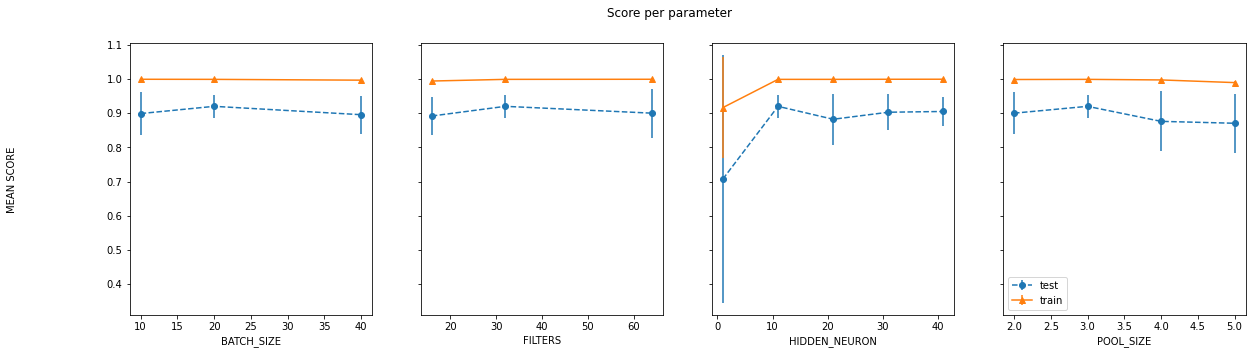

In [139]:

# Calling Method 
plot_search_results(grid_result)

In [140]:
print("Best score: ", grid_result.best_score_)
print("Best parameters set: ", grid_result.best_params_)

Best score:  0.9204286694526672
Best parameters set:  {'batch_size': 20, 'filters': 32, 'hidden_neuron': 11, 'pool_size': 3}


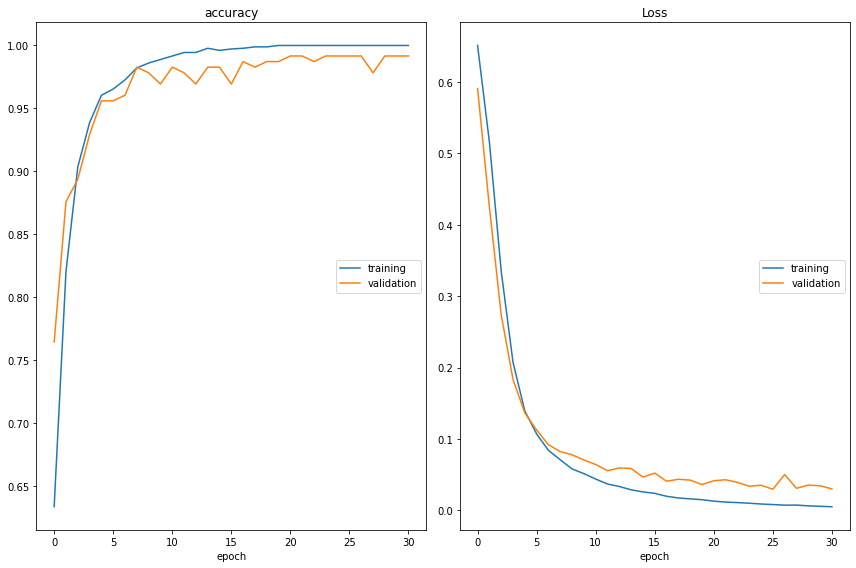

accuracy
	training         	 (min:    0.634, max:    0.999, cur:    0.999)
	validation       	 (min:    0.764, max:    0.991, cur:    0.991)
Loss
	training         	 (min:    0.005, max:    0.651, cur:    0.005)
	validation       	 (min:    0.029, max:    0.591, cur:    0.030)
90/90 [==============================] - 0s 4ms/step - loss: 0.0049 - accuracy: 0.9994 - val_loss: 0.0299 - val_accuracy: 0.9911


In [148]:
# model = create_model(shape=(k,9),**grid_result.best_params_)
# model.fit(train_X, train_Y, batch_size=64, epochs=20,
#                     validation_data=(test_X, test_Y),
#                     callbacks=[PlotLossesKeras(),
#                                early_stop])
model = create_model(shape=(k,9),**grid_result.best_params_)
model.fit(train_X, train_Y, batch_size=20, epochs=50,
                    validation_data=(vald_X, vald_Y),
                    callbacks=[PlotLossesKeras(),
                               early_stop,
                               ModelCheckpoint(filepath=models_path + '/model_10.hdf5',save_best_only=True)
                               ])  

C:\Users\Patryk\AppData\Local\Temp\ipykernel_15788\195074157.py:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<Figure size 1296x720 with 0 Axes>

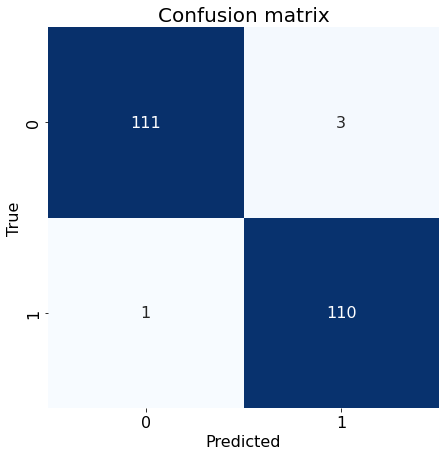

In [149]:
out_Y = model.predict(test_X, verbose=0)
out_Y = [0 if x<0.5 else 1 for x in out_Y]
matrix = sklearn.metrics.confusion_matrix(test_Y, out_Y)

plt.figure()

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)

cm = sklearn.metrics.confusion_matrix(test_Y, out_Y)
sns.heatmap(
    cm, 
    annot=True, 
    annot_kws={"size": 16},
    fmt='d', 
    cmap=plt.cm.Blues,
    cbar=False,
    ax=ax
)
ax.set_title("Confusion matrix", fontsize=20)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=16)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)
ax.set_ylabel('True', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)

fig.show()